# Analysis and modeling of computational Theory of Mind project

#### Author: Giovanni Gentile, Ph.D.
Institution: California Institute of Technology

Contact: gentile.giovanni `at` gmail.com

## Contents:

### 1. Introduction
### 2. Load libraries and dataset
### 3. Cleaning and preparing data
### 4. Visualize experimental design data
### 5. Visualize behavioral data: Reaction time
### 6. Visualize behavioral data: Choices
### 7. Visualize behavioral data: Choice accuracy
### 8. Modeling choice data: Predictive models

## 1. Introduction

This notebook contains a collection of exploratory data analysis, feature engineering, and statistical modeling for a project conducted by Giovanni Gentile at the California Institute of Technology. 

For questions and access to the full dataset, please contact the author at gentile.giovanni `at` gmail.com

## 2. Load libraries and dataset

In [610]:
# List libraries to load
packages <- c("dplyr", "tidyr", "purrr", "corrplot", "ggplot2", "grid", "gridExtra", "ggthemes", "scales", "repr", "RColorBrewer", "lme4")

# Load required libraries
options(warn = -1)
purrr::walk(packages, library, character.only = TRUE, warn.conflicts = FALSE)

# Load dataset
data <- read.csv("behavioral_data.csv", header = FALSE, stringsAsFactors = FALSE)

## 3. Cleaning and preparing data

In [611]:
# Visualize structure and summary of dataset
str(data)

head(data)

'data.frame':	11520 obs. of  11 variables:
 $ V1 : int  1 1 1 1 1 1 1 1 1 1 ...
 $ V2 : int  1 2 3 4 5 6 7 8 9 10 ...
 $ V3 : int  20 20 40 60 20 40 80 20 80 80 ...
 $ V4 : int  4 4 2 2 10 8 2 4 6 8 ...
 $ V5 : int  1 1 2 0 0 2 1 1 5 6 ...
 $ V6 : int  1 1 1 1 1 1 1 1 1 1 ...
 $ V7 : int  40 20 20 60 40 60 80 40 80 80 ...
 $ V8 : num  1 1 0 0 0 0 0 1 1 1 ...
 $ V9 : num  3.68 2.98 1.49 2.41 2.69 ...
 $ V10: int  1 1 1 1 1 1 1 1 1 1 ...
 $ V11: int  1 1 1 1 1 1 1 1 1 1 ...


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
1,1,20,4,1,1,40,1,3.6776,1,1
1,2,20,4,1,1,20,1,2.9792,1,1
1,3,40,2,2,1,20,0,1.4871,1,1
1,4,60,2,0,1,60,0,2.4109,1,1
1,5,20,10,0,1,40,0,2.6895,1,1
1,6,40,8,2,1,60,0,2.7099,1,1


The dataset contains 11520 observations of 11 variables. The following code will replace the uninformative column headers (variable names) with the appropriate names from the experimental design and measures.

In [612]:
# Rename columns based on the way the experimental data were logged during data collection
data <- data %>% rename(subjectID = V1, trialID = V2, trueCoin = V3, seqLength = V4, nHeads = V5, condition = V6,
                        questionCoin = V7, choice = V8, RT = V9, condSession = V10, totSession = V11)

In [613]:
# Visualize summary of dataset with updated column names
summary(data)

   subjectID        trialID          trueCoin    seqLength      nHeads     
 Min.   : 1.00   Min.   :  1.00   Min.   :20   Min.   : 2   Min.   : 0.00  
 1st Qu.: 8.75   1st Qu.: 90.75   1st Qu.:35   1st Qu.: 4   1st Qu.: 1.00  
 Median :16.50   Median :180.50   Median :50   Median : 6   Median : 2.00  
 Mean   :16.50   Mean   :180.50   Mean   :50   Mean   : 6   Mean   : 2.99  
 3rd Qu.:24.25   3rd Qu.:270.25   3rd Qu.:65   3rd Qu.: 8   3rd Qu.: 4.00  
 Max.   :32.00   Max.   :360.00   Max.   :80   Max.   :10   Max.   :10.00  
                                                                           
   condition    questionCoin     choice             RT           condSession
 Min.   :0.0   Min.   :20    Min.   :0.0000   Min.   :0.05483   Min.   :1   
 1st Qu.:0.0   1st Qu.:40    1st Qu.:0.0000   1st Qu.:1.56140   1st Qu.:1   
 Median :0.5   Median :50    Median :1.0000   Median :1.98000   Median :2   
 Mean   :0.5   Mean   :50    Mean   :0.5456   Mean   :2.06209   Mean   :2   
 3rd Qu

Turn `subjectID`, `trialID`, `condition`, `session`, `condSession`, and `totSession` variables into factors for visualization and analyses purposes.

In [614]:
# Turn appropriate variables (columns) into factors
data$trialID[data$condition == 0] <- data$trialID[data$condition == 0] - 180
data$subjectID   <- factor(data$subjectID)
data$trialID     <- factor(data$trialID)
data$condition   <- factor(data$condition, levels = c(1, 0), labels = c("coinKnown", "coinUnknown"))
data$condSession <- factor(data$condSession)
data$totSession  <- factor(data$totSession)

When participants failed to make a choice before the end of each trial, the variables `choice` and `RT` were coded as `NAs`. The following code generates on overview of missing data for each subject and experimental condition, and then proceeds to eliminate missing trials from the the cleaned dataset.

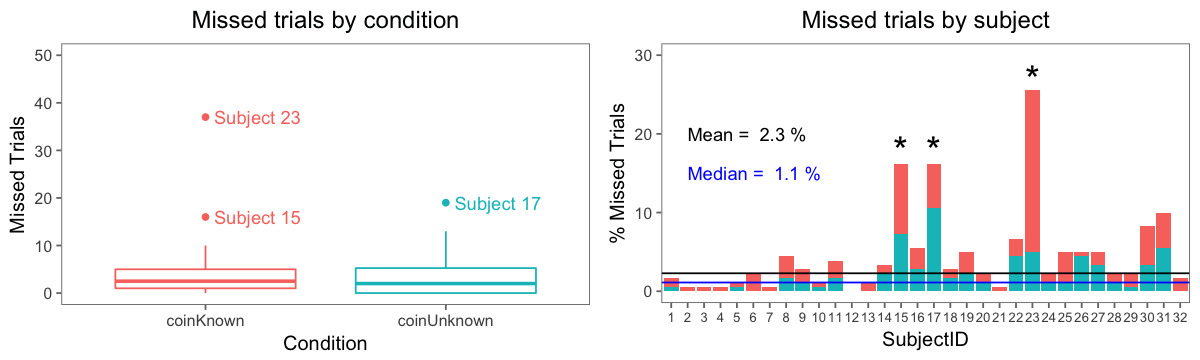

In [615]:
# Extract and visualize missed trials stats per subject, condition
missed_trials <- data %>% group_by(subjectID, condition) %>%
                          summarise(nMissed = sum(is.na(RT)), pctMissed = sum(is.na(RT))/180*100)


# Identify outliers for each condition
outliers <- missed_trials %>% ungroup() %>% mutate(outlier = (nMissed - quantile(missed_trials$nMissed, 0.75)) > 2 * IQR(missed_trials$nMissed)) %>%
                              filter(outlier)

# Visualize missing data for each subject and condition
missed.bar.plot <- missed_trials %>% ggplot(aes(x = subjectID, y = pctMissed, fill = condition)) +
                                     geom_bar(stat = "identity") + theme_bw() +
                                     geom_hline(yintercept = mean(missed_trials$pctMissed), color = "black") +
                                     geom_hline(yintercept = median(missed_trials$pctMissed), color = "blue") +
                                     annotate(geom = "text", x = 2, y = 20, hjust = 0,
                                              label = paste("Mean = ", round(mean(missed_trials$pctMissed), 1), "%"),
                                              color = "black") +
                                     annotate(geom = "text", x = 2, y = 15, hjust = 0,
                                              label = paste("Median = ", round(median(missed_trials$pctMissed), 1), "%"),
                                              color = "blue") +
                                     geom_text(data = outliers, aes(x = subjectID, y = c(18, 18, 27), label = "*"), size = 8) +
                                     labs(title = "Missed trials by subject", x = "SubjectID", y = "% Missed Trials") +
                                     scale_y_continuous(limits = c(0, 30)) +                                    
                                     ggthemes::theme_few() +
                                     theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(size = 8)) +
                                     guides(fill = FALSE)

# Visualize distribution of missing data within each condition and label outliers
missed.box.plot <- missed_trials %>% ggplot(aes(x = factor(condition), y = nMissed, color = condition)) +
                                     geom_boxplot() +
                                     geom_text(data = outliers, aes(label = paste("Subject", subjectID)), hjust = -0.1) +
                                     labs(title = "Missed trials by condition", x = "Condition", y = "Missed Trials") +
                                     scale_y_continuous(limits = c(0, 50)) +
                                     ggthemes::theme_few() +
                                     theme(plot.title = element_text(hjust = 0.5)) + guides(color = FALSE)

options(repr.plot.width = 10, repr.plot.height = 3)

grid.arrange(missed.box.plot, missed.bar.plot, nrow = 1, ncol = 2)


In [616]:
# Decide whether to remove outliers (in terms of missed trials)
outliers.missedTrials.remove <- FALSE
if (outliers.missedTrials.remove) {
    data <- data %>% filter(!(subjectID %in% outliers$subjectID))
}

Let's just check that there are no significant differences between the two experimental conditions in terms of missed trials. Missed trials will then be removed from the cleaned dataset.

In [617]:
# Check for differences in missing data between the two conditions
wilcox.test(missed_trials$nMissed[missed_trials$condition == "coinKnown"], missed_trials$nMissed[missed_trials$condition == "coinUnknown"], paired = TRUE, exact = FALSE)


	Wilcoxon signed rank test with continuity correction

data:  missed_trials$nMissed[missed_trials$condition == "coinKnown"] and missed_trials$nMissed[missed_trials$condition == "coinUnknown"]
V = 208.5, p-value = 0.2167
alternative hypothesis: true location shift is not equal to 0


No significant difference in missed trials between the two conditions. Save cleaned dataset after removing missed trials.

In [618]:
data <- data %>% filter(!is.na(RT))

Having removed the missed trials from the `choice` and `RT` variables, `choice` can now be converted into a factor variable for further visualization and analyses.

In [619]:
data$choice <- factor(data$choice, levels = c(0, 1), labels = c("no", "yes"))

## 4. Visualize experimental design data and build features of interest

The following block of code visualizes the experimental data of interest, compares the distribution of relevant variables between conditions, and builds features of interest to model the behavioral choice data.

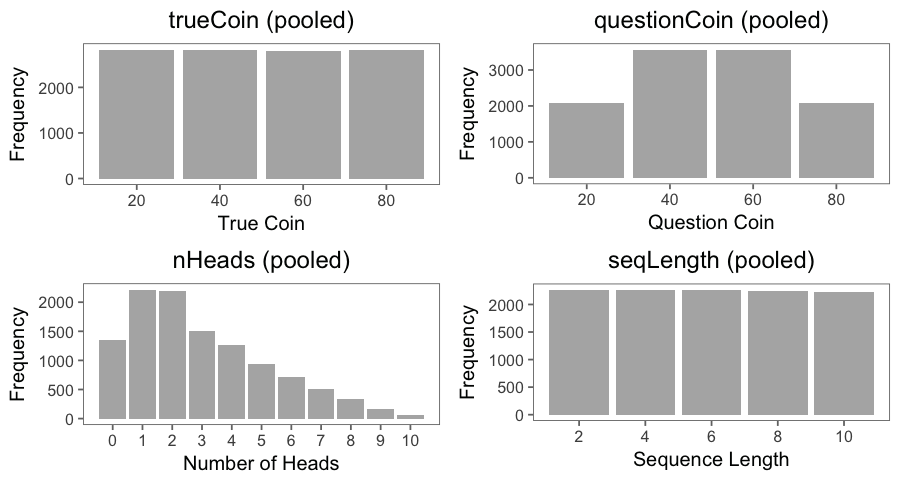

In [620]:
# Visualize distributions of experimental variables: trueCoin, questionCoin, nHeads, seqLength

# Pooled trials:

# Visualize distribution of trueCoin variable
trueCoin.pooled.plot <- data %>% ggplot(aes(x = trueCoin)) + geom_bar(alpha = 0.5) + scale_x_continuous(breaks = c(20, 40, 60, 80)) +
                        labs(title = "trueCoin (pooled)", x = "True Coin", y = "Frequency") +
                        ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))
             
# Visualize distribution of questionCoin variable
questionCoin.pooled.plot <- data %>% ggplot(aes(x = questionCoin)) + geom_bar(alpha = 0.5) + scale_x_continuous(breaks = c(20, 40, 60, 80)) +
                            labs(title = "questionCoin (pooled)", x = "Question Coin", y = "Frequency") +
                            ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize distribution of nHeads variable
nHeads.pooled.plot <- data %>% ggplot(aes(x = nHeads)) + geom_bar(alpha = 0.5) + scale_x_continuous(breaks = seq(0, 10)) +
                      labs(title = "nHeads (pooled)", x = "Number of Heads", y = "Frequency") +
                      ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize distribution of seqLength variable
seqLength.pooled.plot <- data %>% ggplot(aes(x = seqLength)) + geom_bar(alpha = 0.5) + scale_x_continuous(breaks = seq(2, 10, 2)) +
                         labs(title = "seqLength (pooled)", x = "Sequence Length", y = "Frequency") +
                         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 7.5, repr.plot.height = 4)

grid.arrange(trueCoin.pooled.plot, questionCoin.pooled.plot, nHeads.pooled.plot, seqLength.pooled.plot, nrow = 2, ncol = 2)


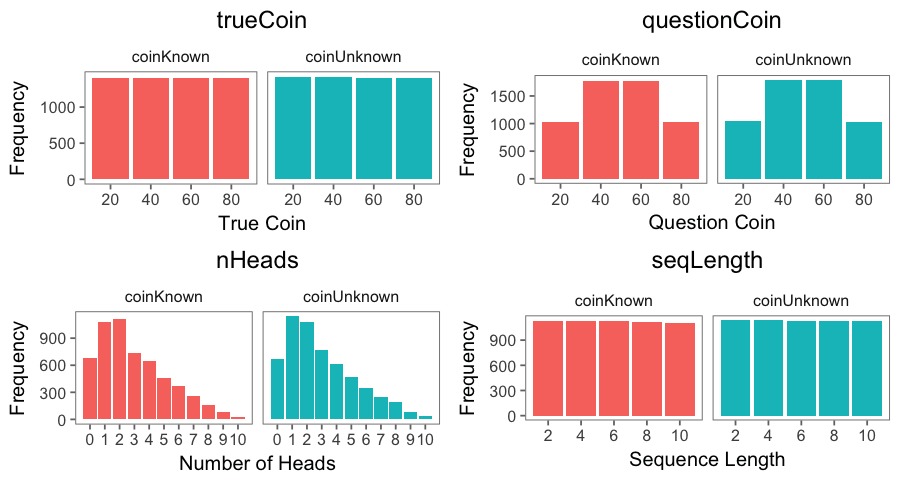

In [621]:
# By condition:

# Visualize distribution of trueCoin variable by condition
trueCoin.bycond.plot <- data %>% ggplot(aes(x = trueCoin, fill = condition)) + geom_bar() +
                        facet_grid(. ~ condition) + guides(fill = FALSE) +
                        scale_x_continuous(breaks = c(20, 40, 60, 80)) +
                        labs(title = "trueCoin", x = "True Coin", y = "Frequency") +
                        ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))
    
# Visualize distribution of questionCoin variable by condition
questionCoin.bycond.plot <- data %>% ggplot(aes(x = questionCoin, fill = condition)) + geom_bar() +
                            facet_grid(. ~ condition) + guides(fill = FALSE) +
                            scale_x_continuous(breaks = c(20, 40, 60, 80)) +
                            labs(title = "questionCoin", x = "Question Coin", y = "Frequency") +
                            ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize distribution of nHeads variable by condition
nHeads.bycond.plot <- data %>% ggplot(aes(x = nHeads, fill = condition)) + geom_bar() +
                      facet_grid(. ~ condition) + guides(fill = FALSE) +
                      scale_x_continuous(breaks = seq(0, 10, 1)) +
                      labs(title = "nHeads", x = "Number of Heads", y = "Frequency") +
                      ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize distribution of seqLength variable by condition
seqLength.bycond.plot <- data %>% ggplot(aes(x = seqLength, fill = condition)) + geom_bar() +
                         facet_grid(. ~ condition) + guides(fill = FALSE) +
                         scale_x_continuous(breaks = seq(2, 10, 2)) +
                         labs(title = "seqLength", x = "Sequence Length", y = "Frequency") +
                         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 7.5, repr.plot.height = 4)

grid.arrange(trueCoin.bycond.plot, questionCoin.bycond.plot, nHeads.bycond.plot, seqLength.bycond.plot, nrow = 2, ncol = 2)

Let's build and visualize a number of features generated from the experimental design variables:
1. A congruence indicator, representing a match or mismatch between the `trueCoin` and the `questionCoin`
2. pData: the proportion of heads in the trial sequence = `nHeads` / `seqLength` * 100
3. pRelData: absolute difference between pData and questionCoin = `abs(pData - questionCoin`
4. pRelTrue: absolute difference between trueCoin and questionCoin = `abs(trueCoin - questionCoin)`

In [622]:
# Add congruence factor: trueCoin == questionCoin
data <- data %>% mutate(cong = trueCoin == questionCoin)
data$cong <- factor(data$cong, levels = c(FALSE, TRUE), labels = c("incongruent", "congruent"))

# Add pData: proportion of heads in trial sequence 
data <- data %>% mutate(pData = (nHeads / seqLength) * 100)

# Add pRelData: absolute difference between pData and questionCoin
data <- data %>% mutate(pRelData = abs(pData - questionCoin))

# Add pRelTrue: absolute difference between trueCoin and questionCoin
data <- data %>% mutate(pRelTrue = abs(trueCoin - questionCoin))

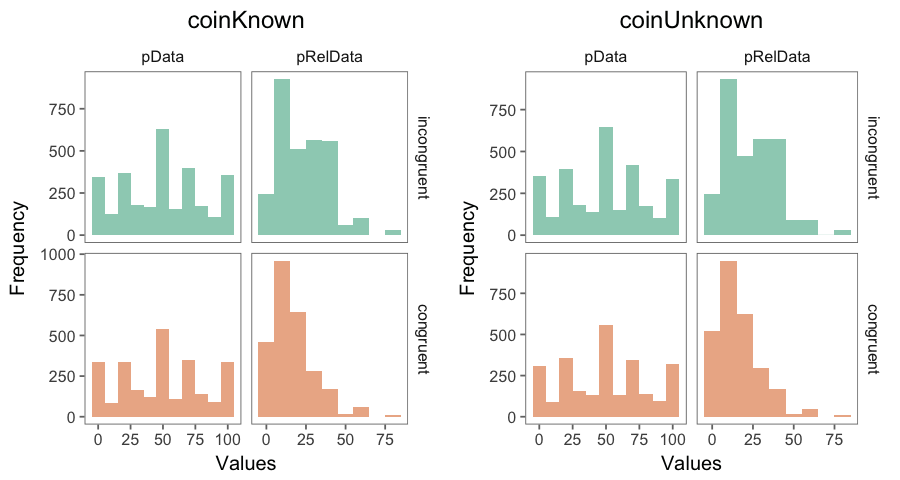

In [623]:
# Visualize added features by condition and congruence

# Visualize pData, pRelData by cong for condition == "coinKnown"
plot.coinKnown <- data %>% select(pData, pRelData, condition, cong) %>%
                           filter(condition == "coinKnown") %>%
                           gather(key = variable, value = value, -cong, -condition) %>%
                           ggplot(aes(x = value, fill = cong)) +
                           scale_fill_brewer(palette = "Dark2") +
                           geom_histogram(binwidth = 10, alpha = 0.5) +
                           facet_grid(cong ~ variable, scales = "free") + guides(fill = FALSE) +
                           labs(title = "coinKnown", x = "Values", y = "Frequency") +
                           ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize pData, pRelData by cong for condition == "coinUnknown"
plot.coinUnknown <- data %>% select(pData, pRelData, condition, cong) %>%
                             filter(condition == "coinUnknown") %>%
                             gather(key = variable, value = value, -cong, -condition) %>%
                             ggplot(aes(x = value, fill = cong)) +
                             scale_fill_brewer(palette = "Dark2") +
                             geom_histogram(binwidth = 10, alpha = 0.5) +
                             facet_grid(cong ~ variable, scales = "free") + guides(fill = FALSE) +
                             labs(title = "coinUnknown", x = "Values", y = "Frequency") +
                             ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 7.5, repr.plot.height = 4)

grid.arrange(plot.coinKnown, plot.coinUnknown, nrow = 1, ncol = 2)

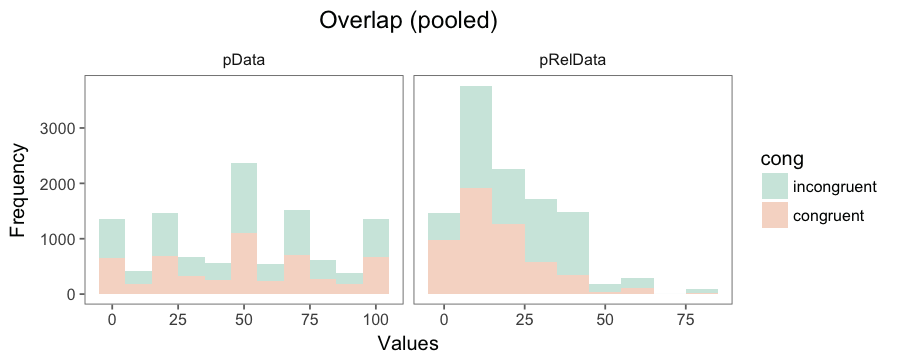

In [624]:
# Visualize overlap (pooled across conditions)
options(repr.plot.width = 7.5, repr.plot.height = 3)

# Visualize overlap and differences between the distributions of pData and pReldata by the congruence factor
data %>% select(pData, pRelData, cong) %>%
         gather(key = variable, value = value, -cong) %>%
         ggplot(aes(x = value, fill = cong)) +
         scale_fill_brewer(palette = "Dark2") +
         geom_histogram(binwidth = 10, alpha = 0.25) +
         facet_grid(. ~ variable, scales = "free") +
         labs(title = "Overlap (pooled)", x = "Values", y = "Frequency") +
         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5)) 

In [625]:
# Add a feature representing the trial-wise Bayesian posterior probability for each question

# Define function to compute posterior probability of coin specified in the question that appears on each trial
calculate_posteriorQ <- function(questionCoin, nHeads, seqLength) {
  
  likelihood_coin20   <- .2^nHeads * .8^(seqLength - nHeads)
  likelihood_coin40   <- .4^nHeads * .6^(seqLength - nHeads)
  likelihood_coin60   <- .6^nHeads * .4^(seqLength - nHeads)
  likelihood_coin80   <- .8^nHeads * .2^(seqLength - nHeads)
  marginal_likelihood <- likelihood_coin20 + likelihood_coin40 + likelihood_coin60 + likelihood_coin80
  
  if (questionCoin == 20) {
    return(likelihood_coin20 / marginal_likelihood)
  } else if (questionCoin == 40) {
      return(likelihood_coin40 / marginal_likelihood)
  } else if (questionCoin == 60) {
      return(likelihood_coin60 / marginal_likelihood)
  } else if (questionCoin == 80) {
      return(likelihood_coin80 / marginal_likelihood)
  }
}

# Add posteriorQ to data frame
data <- data %>% mutate(posteriorQ = mapply(calculate_posteriorQ, questionCoin, nHeads, seqLength))

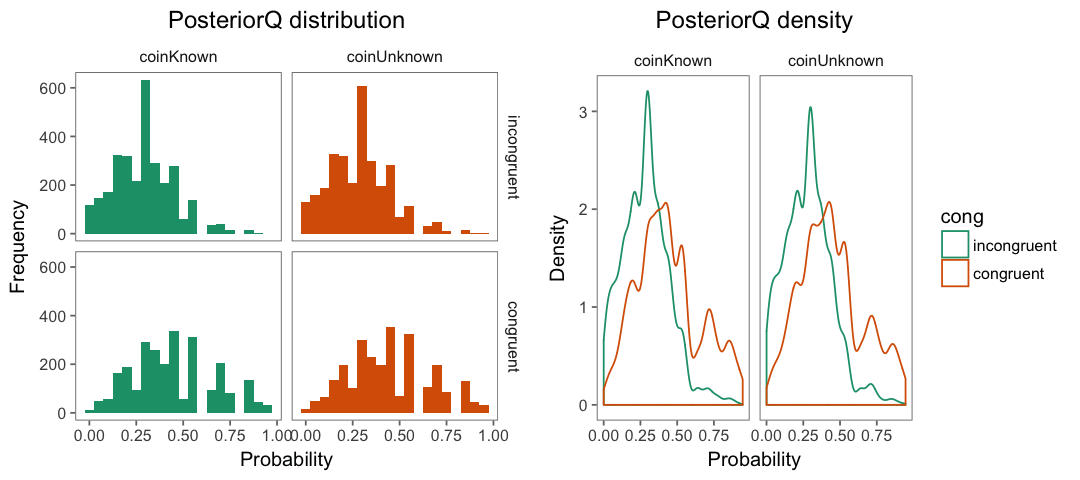

In [626]:
# Visualize distribution of posteriorQ by condition and congruence

options(repr.plot.width = 9, repr.plot.height = 4)

# Visualize histogram of posteriorQ by condition and congruence factors
posteriorQ.hist <- data %>% ggplot(aes(x = posteriorQ, fill = condition)) + geom_histogram(binwidth = 0.05) +
                   scale_fill_brewer(palette = "Dark2") +
                   facet_grid(cong ~ condition, scales = "free_x") +
                   guides(fill=FALSE) +                           
                   labs(title = "PosteriorQ distribution", x = "Probability", y = "Frequency") +
                   ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize density of posteriorQ by condition and congruence factors
posteriorQ.dens <- data %>% ggplot(aes(x = posteriorQ, color = cong)) + geom_density() +
                   scale_color_brewer(palette = "Dark2") +
                   facet_grid(. ~ condition, scales = "free_x") +
                   labs(title = "PosteriorQ density", x = "Probability", y = "Density") +
                   ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

grid.arrange(posteriorQ.hist, posteriorQ.dens, nrow = 1, ncol = 2)

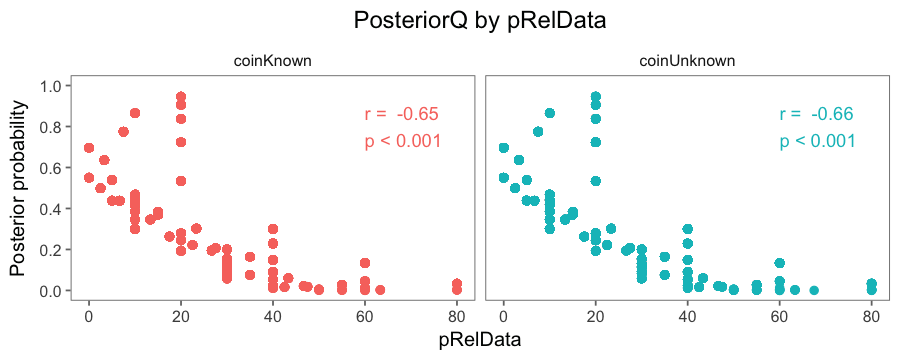

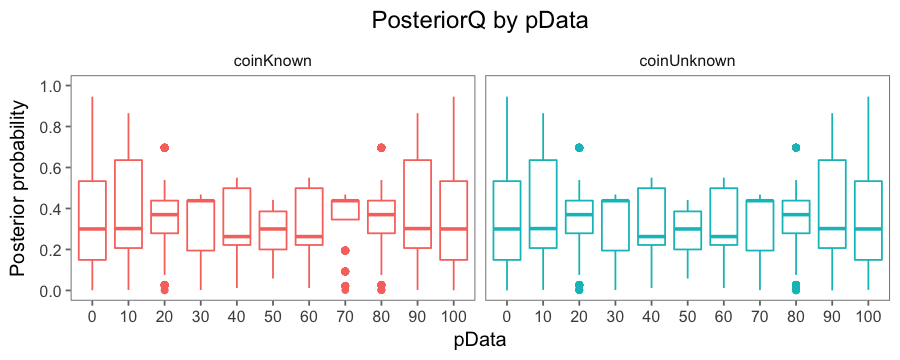

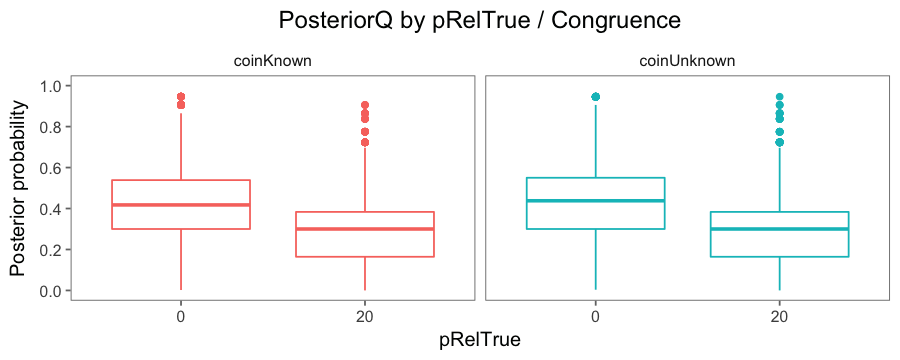

In [627]:
# Visualize relationship between the posterior probability and the features pRelData, pData, and pRelTrue

options(repr.plot.width = 7.5, repr.plot.height = 3)


# Compute correlation coefficient (and test for significance) for posteriorQ and pRelData correlation
corr.postQ.pRelData <- data %>% select(condition, posteriorQ, pRelData) %>%
                                group_by(condition) %>%
                                summarise(corr = cor(pRelData, posteriorQ),
                                          pvalue = cor.test(pRelData, posteriorQ)$p.value)

# Visualize correlation of pRelData and posteriorQ by condition
data %>% ggplot(aes(x = pRelData, y = posteriorQ, color = condition)) +
         geom_point(size = 2) +
         #stat_smooth(method = "lm", se = FALSE, color = "black", lwd = 0.5) +
         geom_text(data = corr.postQ.pRelData, aes(x = 60, y = 0.8,
                   label = paste("r = ", round(corr, 2), "\np < 0.001"), hjust = 0)) +
         scale_y_continuous(breaks = seq(0, 1, .2), limits = c(0, 1)) +
         scale_x_continuous(breaks = seq(0, 80, 20), limits = c(0, 80)) +
         facet_grid(. ~ condition, scales = "free") +
         guides(color = FALSE) +                           
         labs(title = "PosteriorQ by pRelData", x = "pRelData", y = "Posterior probability") +
         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))
      
# Visualize correlation of pData and posteriorQ by condition
data %>% group_by(condition, pData.bin = cut_interval(pData, n = 11)) %>%
         ggplot(aes(x = pData.bin, y = posteriorQ, color = condition)) +
         geom_boxplot() +
         scale_y_continuous(breaks = seq(0, 1, .2), limits = c(0, 1)) +
         scale_x_discrete(labels = seq(0, 100, 10)) +
         facet_grid(. ~ condition, scales = "free") +
         guides(color = FALSE) +                           
         labs(title = "PosteriorQ by pData", x = "pData", y = "Posterior probability") +
         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize relationship between pRelTrue (~congruence) and posteriorQ by condition
data %>% group_by(condition, factor(pRelTrue)) %>%
         ggplot(aes(x = factor(pRelTrue), y = posteriorQ, color = condition)) +
         geom_boxplot() +
         scale_y_continuous(breaks = seq(0, 1, .2), limits = c(0, 1)) +
         facet_grid(. ~ condition, scales = "free") +
         guides(color = FALSE) +                           
         labs(title = "PosteriorQ by pRelTrue / Congruence", x = "pRelTrue", y = "Posterior probability") +
         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

In [653]:
# Add a feature representing the adjusted trial-wise Bayesian posterior probability for each question

# Define function to compute posterior probability of coin specified in the question that appears on each trial

# Adjusted posterior tries to account for the distribution of trials in the experimental design, i.e., 
# the underlying statistics of the question/true coin pairs.

calculate_posteriorQ_adjusted <- function(questionCoin, nHeads, seqLength) {
  
  likelihood_coin20   <- .2^nHeads * .8^(seqLength - nHeads)
  likelihood_coin40   <- .4^nHeads * .6^(seqLength - nHeads)
  likelihood_coin60   <- .6^nHeads * .4^(seqLength - nHeads)
  likelihood_coin80   <- .8^nHeads * .2^(seqLength - nHeads)
  marginal_likelihood <- likelihood_coin20 + likelihood_coin40 + likelihood_coin60 + likelihood_coin80
  
  if (questionCoin == 20) {
      
    marginal_likelihood <- likelihood_coin20 + likelihood_coin40
    return(likelihood_coin20 / marginal_likelihood)
      
  } else if (questionCoin == 40) {
      
      marginal_likelihood <- likelihood_coin40 + (2/3) * likelihood_coin20 + (1/3) * likelihood_coin60
      return(likelihood_coin40 / marginal_likelihood)
      
  } else if (questionCoin == 60) {
      
      marginal_likelihood <- likelihood_coin60 + (2/3) * likelihood_coin80 + (1/3) * likelihood_coin40
      return(likelihood_coin60 / marginal_likelihood)
      
  } else if (questionCoin == 80) {
      
      marginal_likelihood <- likelihood_coin80 + likelihood_coin60
      return(likelihood_coin80 / marginal_likelihood)
  }
    
}

# Add adjusted posteriorQ to data frame
data <- data %>% mutate(posteriorQ.adjusted = mapply(calculate_posteriorQ_adjusted, questionCoin, nHeads, seqLength))

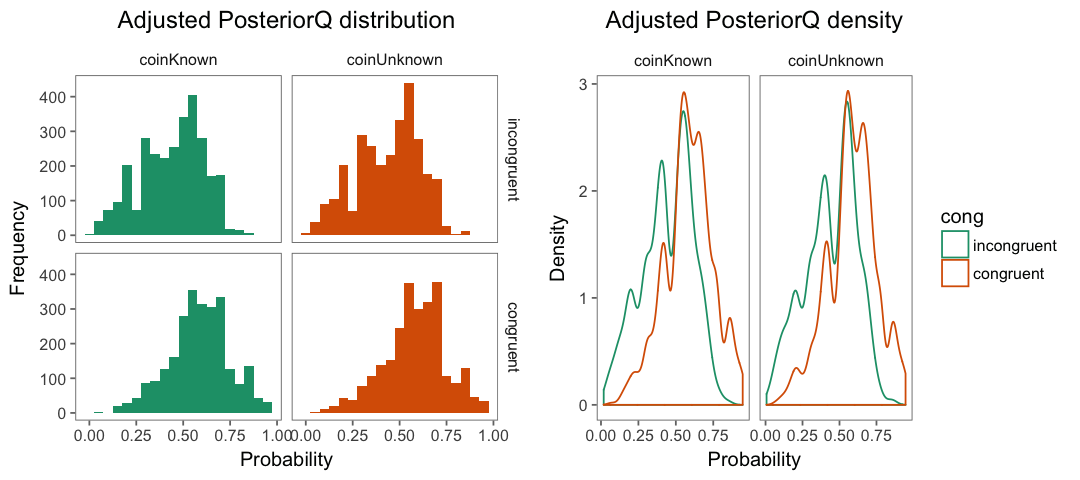

In [654]:
# Visualize distribution of adjusted posteriorQ by condition and congruence

options(repr.plot.width = 9, repr.plot.height = 4)

# Visualize histogram of adjusted posteriorQ by condition and congruence factors
adjusted.posteriorQ.hist <- data %>% ggplot(aes(x = posteriorQ.adjusted, fill = condition)) + geom_histogram(binwidth = 0.05) +
                                     scale_fill_brewer(palette = "Dark2") +
                                     facet_grid(cong ~ condition, scales = "free_x") +
                                     guides(fill=FALSE) +                           
                                     labs(title = "Adjusted PosteriorQ distribution", x = "Probability", y = "Frequency") +
                                     ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize density of adjusted posteriorQ by condition and congruence factors
adjusted.posteriorQ.dens <- data %>% ggplot(aes(x = posteriorQ.adjusted, color = cong)) + geom_density() +
                                     scale_color_brewer(palette = "Dark2") +
                                     facet_grid(. ~ condition, scales = "free_x") +
                                     labs(title = "Adjusted PosteriorQ density", x = "Probability", y = "Density") +
                                     ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

grid.arrange(adjusted.posteriorQ.hist, adjusted.posteriorQ.dens, nrow = 1, ncol = 2)

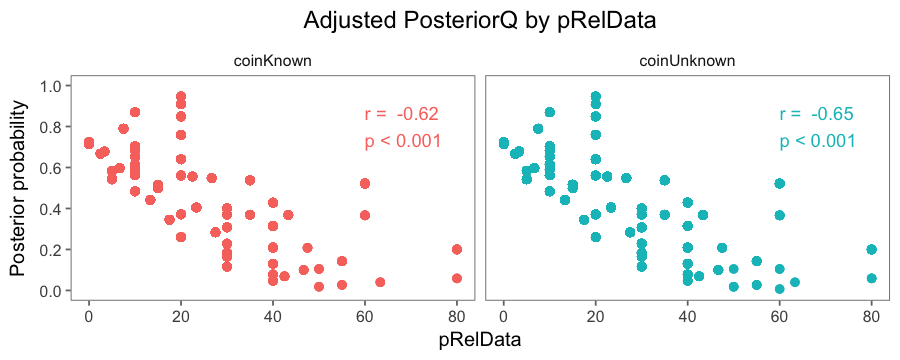

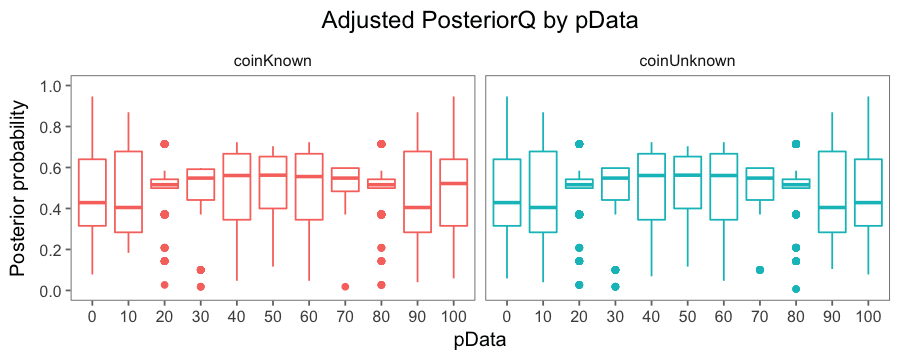

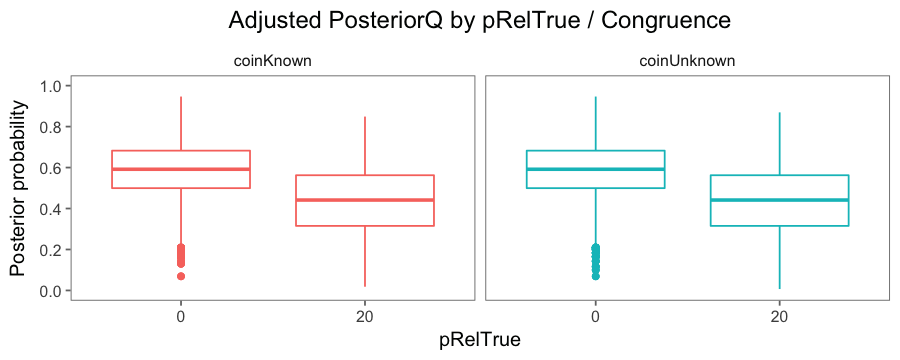

In [656]:
# Visualize relationship between the adjusted posterior probability and the features pRelData, pData, and pRelTrue

options(repr.plot.width = 7.5, repr.plot.height = 3)

# Compute correlation coefficient (and test for significance) for adjusted posteriorQ and pRelData correlation
corr.postQ.adjusted.pRelData <- data %>% select(condition, posteriorQ.adjusted, pRelData) %>%
                                         group_by(condition) %>%
                                         summarise(corr = cor(pRelData, posteriorQ.adjusted),
                                         pvalue = cor.test(pRelData, posteriorQ.adjusted)$p.value)

# Visualize correlation of pRelData and posteriorQ by condition
data %>% ggplot(aes(x = pRelData, y = posteriorQ.adjusted, color = condition)) +
         geom_point(size = 2) +
         #stat_smooth(method = "lm", se = FALSE, color = "black", lwd = 0.5) +
         geom_text(data = corr.postQ.adjusted.pRelData, aes(x = 60, y = 0.8,
                   label = paste("r = ", round(corr, 2), "\np < 0.001"), hjust = 0)) +
         scale_y_continuous(breaks = seq(0, 1, .2), limits = c(0, 1)) +
         scale_x_continuous(breaks = seq(0, 80, 20), limits = c(0, 80)) +
         facet_grid(. ~ condition, scales = "free") +
         guides(color = FALSE) +                           
         labs(title = "Adjusted PosteriorQ by pRelData", x = "pRelData", y = "Posterior probability") +
         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))
      
# Visualize correlation of pData and posteriorQ by condition
data %>% group_by(condition, pData.bin = cut_interval(pData, n = 11)) %>%
         ggplot(aes(x = pData.bin, y = posteriorQ.adjusted, color = condition)) +
         geom_boxplot() +
         scale_y_continuous(breaks = seq(0, 1, .2), limits = c(0, 1)) +
         scale_x_discrete(labels = seq(0, 100, 10)) +
         facet_grid(. ~ condition, scales = "free") +
         guides(color = FALSE) +                           
         labs(title = "Adjusted PosteriorQ by pData", x = "pData", y = "Posterior probability") +
         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

# Visualize relationship between pRelTrue (~congruence) and posteriorQ by condition
data %>% group_by(condition, factor(pRelTrue)) %>%
         ggplot(aes(x = factor(pRelTrue), y = posteriorQ.adjusted, color = condition)) +
         geom_boxplot() +
         scale_y_continuous(breaks = seq(0, 1, .2), limits = c(0, 1)) +
         facet_grid(. ~ condition, scales = "free") +
         guides(color = FALSE) +                           
         labs(title = "Adjusted PosteriorQ by pRelTrue / Congruence", x = "pRelTrue", y = "Posterior probability") +
         ggthemes::theme_few() + theme(plot.title = element_text(hjust = 0.5))

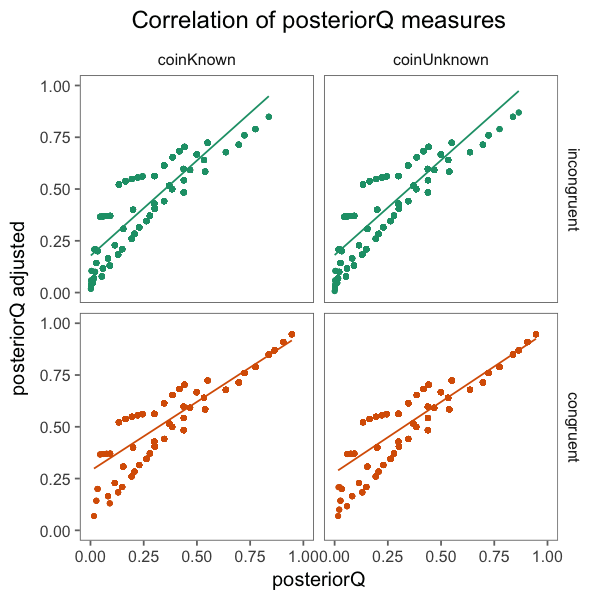

In [677]:
# Visualize correlations between the two different definitions of posteriorQ

options(repr.plot.width = 5, repr.plot.height = 5)

# By condition and congruence
data %>% ggplot(aes(x = posteriorQ, y = posteriorQ.adjusted, color = cong)) +
         geom_point(size = 1) +
         geom_smooth(method = "lm", se = FALSE, lwd = 0.5) + 
         scale_y_continuous(limits = c(0, 1)) +
         scale_x_continuous(limits = c(0, 1)) +
         scale_color_brewer(palette = "Dark2") +
         labs(title = "Correlation of posteriorQ measures", x = "posteriorQ", y = "posteriorQ adjusted") +
         ggthemes::theme_few() +
         theme(plot.title = element_text(hjust = 0.5)) + guides(color = FALSE) +
         facet_grid(cong ~ condition)




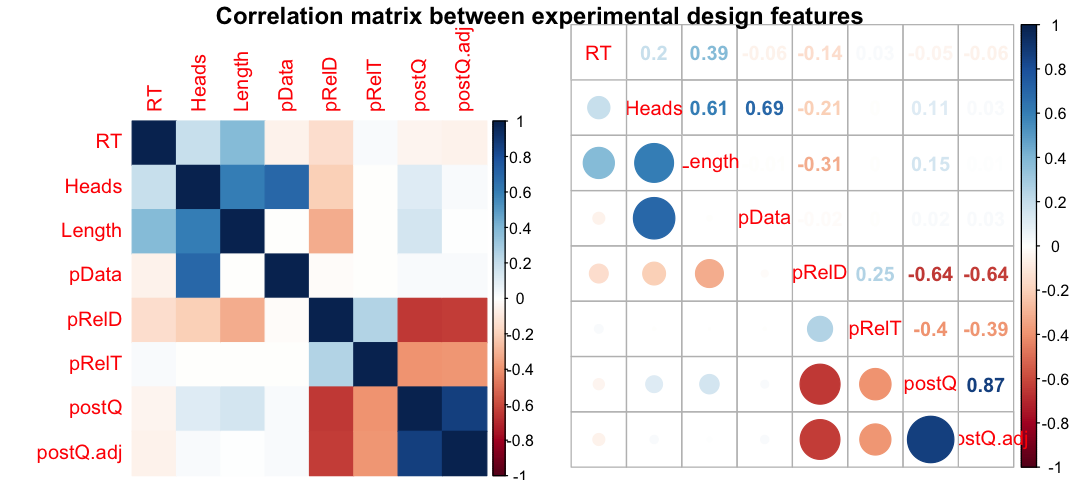

In [769]:
# Visualize correlation between experimental variables and features of interest 

options(repr.plot.width = 9, repr.plot.height = 4)

par(mfrow = c(1,2))

# Select variables to compute correlation matrix
corr.data <- data %>% select(RT = RT, Heads = nHeads, Length = seqLength, pData, pRelD = pRelData, pRelT = pRelTrue, postQ = posteriorQ, postQ.adj = posteriorQ.adjusted)

# Compute and display correlation matrix as color-coded squares
corr.plot.1 <- corrplot(as.matrix(cor(corr.data)), method = "color")

# Compute and display correlation matrix as color-coded circles identifying strength and significance of correlations
# Only significant correlations are displayed
corr.plot.2 <- corrplot.mixed(as.matrix(cor(corr.data)), upper = "number", lower = "circle")

title("Correlation matrix between experimental design features", outer=TRUE, line = -1)

## 5. Visualize behavioral choice data: Reaction time

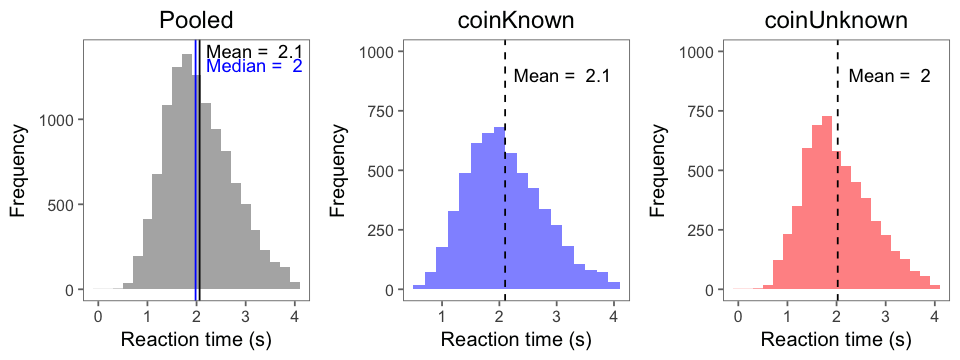

In [629]:
# Visualize distribution of RTs pooled and by condition

# Visualize distribution of RTs pooled across the dataset
RT.pooled.plot <- data %>% select(RT) %>% ggplot(aes(x = RT)) + geom_histogram(binwidth = 0.2, alpha = 0.5) +
                           geom_vline(xintercept = mean(data$RT), color = "black") +
                           geom_vline(xintercept = median(data$RT), color = "blue") +
                           annotate(geom = "text", x = 2.2, y = 1400, hjust = 0,
                                    label = paste("Mean = ", round(mean(data$RT), 1)),
                                    color = "black") +
                           annotate(geom = "text", x = 2.2, y = 1320, hjust = 0,
                                    label = paste("Median = ", round(median(data$RT), 1)),
                                    color = "blue") +   
                           labs(title = "Pooled", x = "Reaction time (s)", y = "Frequency") +
                           ggthemes::theme_few() +
                           theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)

# Visualize distribution of RTs for condition == "coinKnown"
RT.coinKnown.plot <- data %>% filter(condition == "coinKnown") %>% select(RT, condition) %>%
                              ggplot(aes(x = RT)) + geom_histogram(fill = "blue", binwidth = 0.2, alpha = 0.5) +
                              geom_vline(xintercept = mean(data$RT[data$condition == "coinKnown"]), color = "black", linetype = "dashed") +
                              annotate(geom = "text", x = 2.25, y = 900, hjust = 0,
                                       label = paste("Mean = ", round(mean(data$RT[data$condition == "coinKnown"]), 1)),
                                       color = "black") +
                              scale_y_continuous(limits = c(0, 1000)) +
                              labs(title = "coinKnown", x = "Reaction time (s)", y = "Frequency") +
                              ggthemes::theme_few() +
                              theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)

# Visualize distribution of RTs for condition == "coinUnknown"
RT.coinUnknown.plot <- data %>% filter(condition == "coinUnknown") %>% select(RT, condition) %>%
                                ggplot(aes(x = RT)) + geom_histogram(fill = "red", binwidth = 0.2, alpha = 0.5) +
                                geom_vline(xintercept = mean(data$RT[data$condition == "coinUnknown"]), color = "black", linetype = "dashed") +
                                annotate(geom = "text", x = 2.25, y = 900, hjust = 0,
                                         label = paste("Mean = ", round(mean(data$RT[data$condition == "coinUnknown"]), 1)),
                                         color = "black") +
                                scale_y_continuous(limits = c(0, 1000)) +
                                labs(title = "coinUnknown", x = "Reaction time (s)", y = "Frequency") +
                                ggthemes::theme_few() +
                                theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)

options(repr.plot.width = 8, repr.plot.height = 3)

grid.arrange(RT.pooled.plot, RT.coinKnown.plot, RT.coinUnknown.plot, nrow = 1, ncol = 3)

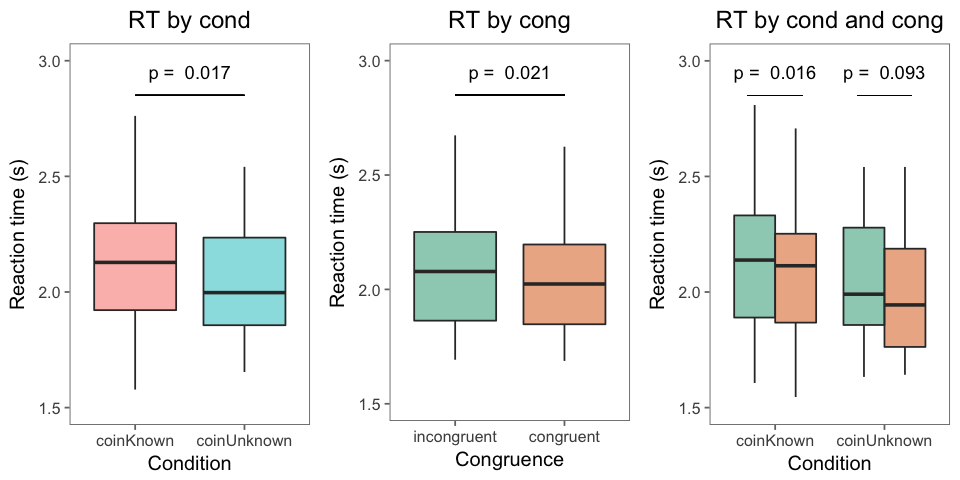

In [630]:
# Compare average RT between conditions and congruence levels

options(repr.plot.width = 8, repr.plot.height = 4)

# Compute average RTs by conditions of interest

# Compute average RT by condition
mean.RT.bycondition <- data %>% select(subjectID, condition, RT) %>%
                                      group_by(condition, subjectID) %>%
                                      summarise(mean.RT = mean(RT), se.RT = sd(RT) / sqrt(n())) %>% ungroup()

# Compute average RT for each level of the congruence factor
mean.RT.bycong <- data %>% select(subjectID, cong, RT) %>%
                           group_by(cong, subjectID) %>%
                           summarise(mean.RT = mean(RT), se.RT = sd(RT) / sqrt(n()))

# Compute average RT for each level condition x congruence
mean.RT.bycondition.bycong <- data %>% select(subjectID, condition, cong, RT) %>%
                                       group_by(condition, cong, subjectID) %>%
                                       summarise(mean.RT = mean(RT), se.RT = sd(RT) / sqrt(n()))

# Statistical comparisons

# By condition:

x <- mean.RT.bycondition$mean.RT[mean.RT.bycondition$condition == "coinKnown"]
y <- mean.RT.bycondition$mean.RT[mean.RT.bycondition$condition == "coinUnknown"]

mean.RT.bycondition.test <- t.test(x, y, paired = TRUE)

# By congruence:

x <- mean.RT.bycong$mean.RT[mean.RT.bycong$cong == "congruent"]
y <- mean.RT.bycong$mean.RT[mean.RT.bycong$cong == "incongruent"]

mean.RT.bycong.test <- t.test(x, y, paired = TRUE)

# By congruence within each condition separately

x <- mean.RT.bycondition.bycong$mean.RT[mean.RT.bycondition.bycong$condition == "coinKnown" & mean.RT.bycondition.bycong$cong == "congruent"]
y <- mean.RT.bycondition.bycong$mean.RT[mean.RT.bycondition.bycong$condition == "coinKnown" & mean.RT.bycondition.bycong$cong == "incongruent"]

mean.RT.bycong.coinKnown.test <- t.test(x, y, paired = TRUE)

x <- mean.RT.bycondition.bycong$mean.RT[mean.RT.bycondition.bycong$condition == "coinUnknown" & mean.RT.bycondition.bycong$cong == "congruent"]
y <- mean.RT.bycondition.bycong$mean.RT[mean.RT.bycondition.bycong$condition == "coinUnknown" & mean.RT.bycondition.bycong$cong == "incongruent"]

mean.RT.bycong.coinUnknown.test <- t.test(x, y, paired = TRUE)

# Visualize plots and statistics

# Visualize summarised RT by condition
mean.RT.bycondition.plot <- mean.RT.bycondition %>%
                            ggplot(aes(x = condition, y = mean.RT, fill = condition)) +
                            geom_boxplot(alpha = 0.5) +
                            geom_segment(aes(x = 1, xend = 2, y = 2.85, yend = 2.85), lwd = 0.25) +
                            annotate(geom = "text", x = 1.5, y = 2.95, hjust = 0.5,
                                     label = paste("p = ", round(mean.RT.bycondition.test$p.value, 3)),
                                     color = "black") +
                            scale_y_continuous(limits = c(1.5, 3)) +
                            labs(title = "RT by cond", x = "Condition", y = "Reaction time (s)") +
                            ggthemes::theme_few() +
                            theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)

# Visualize summarised RT by congruence
mean.RT.bycong.plot <- mean.RT.bycong %>%
                       ggplot(aes(x = cong, y = mean.RT, fill = cong)) +
                       geom_boxplot(alpha = 0.5) +
                       geom_segment(aes(x = 1, xend = 2, y = 2.85, yend = 2.85), lwd = 0.25) +
                       annotate(geom = "text", x = 1.5, y = 2.95, hjust = 0.5,
                                label = paste("p = ", round(mean.RT.bycong.test$p.value, 3)),
                                color = "black") +
                       scale_y_continuous(limits = c(1.5, 3)) +
                       scale_fill_brewer(palette = "Dark2") +
                       labs(title = "RT by cong", x = "Congruence", y = "Reaction time (s)") +
                       ggthemes::theme_few() +
                       theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)

# Visualize summarised RT by condition and congruence
mean.RT.bycondition.bycong.plot <- mean.RT.bycondition.bycong %>% 
                                   ggplot(aes(x = condition, y = mean.RT, fill = cong, position = "dodge")) +
                                   geom_boxplot(alpha = 0.5) +
                                   geom_segment(aes(x = 0.75, xend = 1.25, y = 2.85, yend = 2.85), lwd = 0.25) +
                                   annotate(geom = "text", x = 1, y = 2.95, hjust = 0.5,
                                            label = paste("p = ", round(mean.RT.bycong.coinKnown.test$p.value, 3)),
                                            color = "black") +
                                   geom_segment(aes(x = 1.75, xend = 2.25, y = 2.85, yend = 2.85), lwd = 0.25) +
                                   annotate(geom = "text", x = 2, y = 2.95, hjust = 0.5,
                                            label = paste("p = ", round(mean.RT.bycong.coinUnknown.test$p.value, 3)),
                                            color = "black") +
                                   scale_y_continuous(limits = c(1.5, 3)) +
                                   scale_fill_brewer(palette = "Dark2") +
                                   labs(title = "RT by cond and cong", x = "Condition", y = "Reaction time (s)") +
                                   ggthemes::theme_few() +
                                   theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE, color = FALSE)

grid.arrange(mean.RT.bycondition.plot, mean.RT.bycong.plot, mean.RT.bycondition.bycong.plot, nrow = 1, ncol = 3)

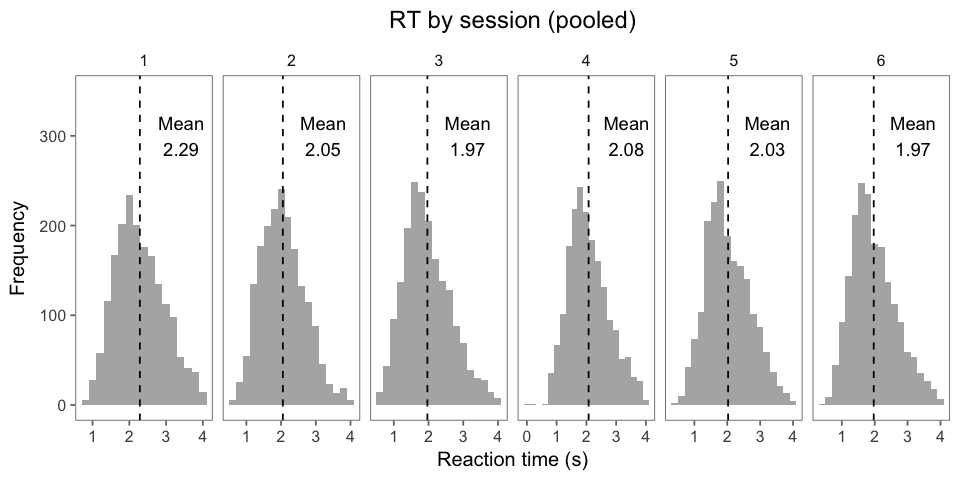

In [631]:
# Visualize RT by session 

# Compute average RT by experimental session
mean.RT.bysession <- data %>% select(RT, totSession) %>%
                              group_by(totSession) %>%
                              summarise(mean.RT = mean(RT))

# Visualize distribution of RTs by experimental session
data %>% select(RT, totSession) %>% ggplot(aes(x = RT)) +
                                    geom_histogram(binwidth = 0.2, alpha = 0.5) +
                                    geom_vline(data = mean.RT.bysession, aes(xintercept = mean.RT), color = "black", linetype = "dashed") +
                                    geom_text(data = mean.RT.bysession, aes(x = mean.RT + 0.5, y = 300,
                                                                            label = paste("Mean\n", round(mean.RT, 2)), hjust = 0)) +
                                    scale_y_continuous(limits = c(0, 350)) +                                    
                                    facet_grid(. ~ totSession, scales = "free") + 
                                    labs(title = "RT by session (pooled)", x = "Reaction time (s)", y = "Frequency") +
                                    ggthemes::theme_few() +
                                    theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)

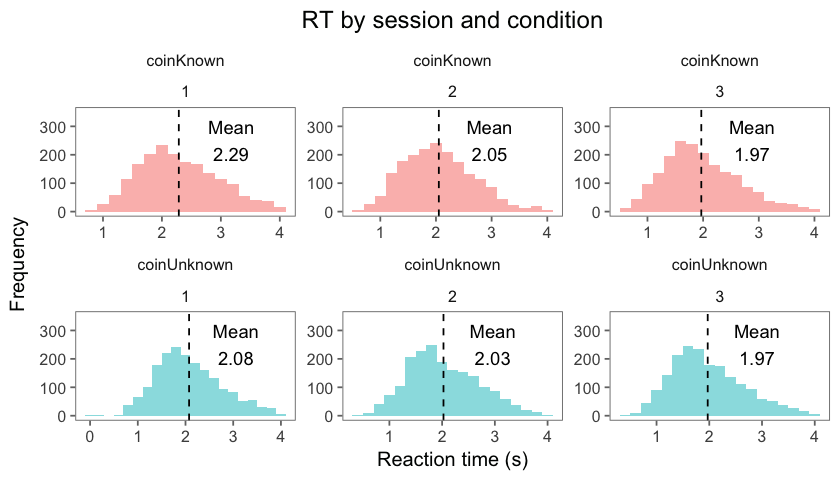

In [632]:
# Visualize RT by session and condition

options(repr.plot.width = 7, repr.plot.height = 4)

# Compute average RT by experimental session for each condition separately
mean.RT.bysession.bycond <- data %>% select(RT, condSession, condition) %>%
                                     group_by(condition, condSession) %>%
                                     summarise(mean.RT = mean(RT), se.RT = sd(RT) / sqrt(n()))

# Visualize distribution of RTs by experimental session for each condition separately
data %>% select(RT, condSession, condition) %>% ggplot(aes(x = RT, fill = condition)) +
                                                geom_histogram(binwidth = 0.2, alpha = 0.5) +
                                                geom_vline(data = mean.RT.bysession.bycond, aes(xintercept = mean.RT), color = "black", linetype = "dashed") +
                                                geom_text(data = mean.RT.bysession.bycond, aes(x = mean.RT + 0.5, y = 250,
                                                                                               label = paste("Mean\n", round(mean.RT, 2)), hjust = 0)) +
                                                scale_y_continuous(limits = c(0, 350)) +                                    
                                                facet_wrap(condition ~ condSession, scales = "free") + 
                                                labs(title = "RT by session and condition", x = "Reaction time (s)", y = "Frequency") +
                                                ggthemes::theme_few() +
                                                theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)

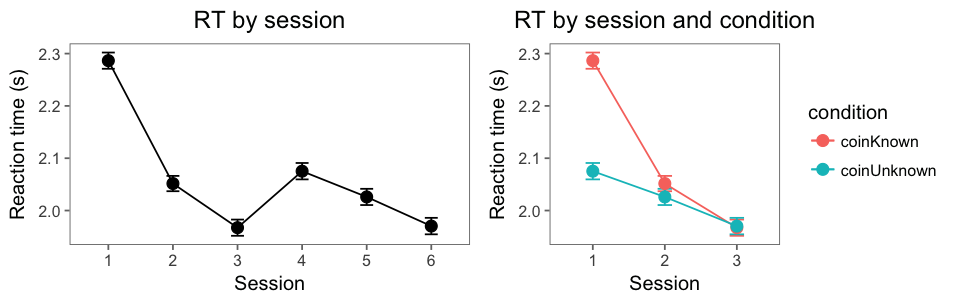

In [633]:
options(repr.plot.width = 8, repr.plot.height = 2.5)

# Compute average RT by experimental session
mean.RT.bysession <- data %>% select(RT, totSession) %>%
                              group_by(totSession) %>%
                              summarise(mean.RT = mean(RT), se.RT = sd(RT) / sqrt(n()))

# Visualize change in average RT by session
RT.bysession.plot <- mean.RT.bysession %>% ungroup() %>% ggplot() +                       
                     geom_errorbar(data = mean.RT.bysession, aes(x = totSession, ymin = mean.RT - se.RT, ymax = mean.RT + se.RT), width = 0.2) +
                     geom_line(data = mean.RT.bysession, aes(x = totSession, y = mean.RT, group = 1)) +
                     geom_point(data = mean.RT.bysession, aes(x = totSession, y = mean.RT), size = 3) +
                     labs(title = "RT by session", x = "Session", y = "Reaction time (s)") +
                     ggthemes::theme_few() +
                     theme(plot.title = element_text(hjust = 0.5))

# Visualize change in average RT by session for each condition separately and overlap onto same plot
RT.bysession.bycond.plot <- mean.RT.bysession %>% ggplot() +                       
                            geom_errorbar(data = mean.RT.bysession.bycond, aes(x = condSession, ymin = mean.RT - se.RT, ymax = mean.RT + se.RT, group = condition, color = condition), width = 0.2) +
                            geom_line(data = mean.RT.bysession.bycond, aes(x = condSession, y = mean.RT, group = condition, color = condition)) +
                            geom_point(data = mean.RT.bysession.bycond, aes(x = condSession, y = mean.RT, group = condition, color = condition), size = 3) +
                            labs(title = "RT by session and condition", x = "Session", y = "Reaction time (s)") +
                            ggthemes::theme_few() +
                            theme(plot.title = element_text(hjust = 0.5))

grid.arrange(RT.bysession.plot, RT.bysession.bycond.plot, nrow = 1, ncol = 2)


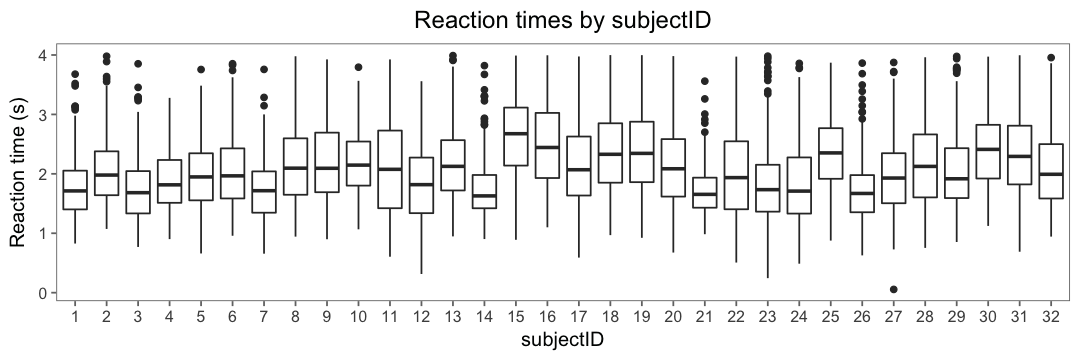

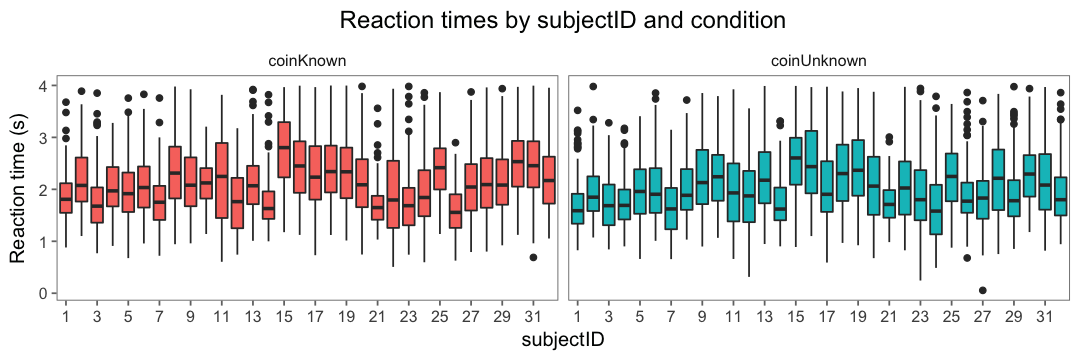

In [634]:
# Visualize RT by subjectID and condition

options(repr.plot.width = 9, repr.plot.height = 3)

# By subject, pooled data
data %>% select(RT, subjectID) %>% ggplot(aes(x = subjectID, y = RT)) +
                                   geom_boxplot() +
                                   labs(title = "Reaction times by subjectID", y = "Reaction time (s)", x = "subjectID") +
                                   ggthemes::theme_few() +
                                   theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)
# By subject and condition
data %>% select(RT, subjectID, condition) %>% ggplot(aes(x = subjectID, y = RT, fill = condition)) +
                                              geom_boxplot() + 
                                              scale_x_discrete(breaks = seq(1, 32, 2), labels = seq(1, 32, 2)) +
                                              facet_grid(. ~ condition, scales = "free_x") + 
                                              labs(title = "Reaction times by subjectID and condition", y = "Reaction time (s)", x = "subjectID") +
                                              ggthemes::theme_few() +
                                              theme(plot.title = element_text(hjust = 0.5)) + guides(fill = FALSE)

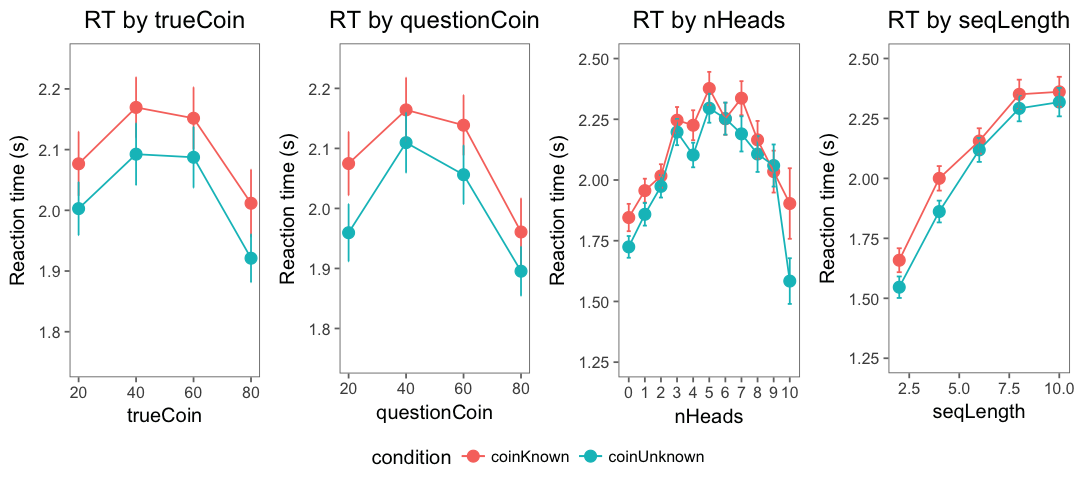

In [635]:
# Visualize RT by experimental design features

options(repr.plot.width = 9, repr.plot.height = 4)

# Average RTs by trueCoin, questionCoin, nHeads, seqLength (by condition)

# By trueCoin:
data %>% select(subjectID, condition, trueCoin, RT) %>%
         group_by(subjectID, condition, trueCoin) %>%
         summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n())) %>%
         ungroup() %>%
         group_by(condition, trueCoin) %>%
         summarise(mean.RT.trueCoin = mean(mean.RT), se.RT.trueCoin = sd(mean.RT) / sqrt(n())) %>%
         ggplot() + geom_point(aes(x = trueCoin, y = mean.RT.trueCoin, color = condition), size = 3) +
                    geom_errorbar(aes(x = trueCoin, ymin = mean.RT.trueCoin - se.RT.trueCoin, ymax = mean.RT.trueCoin + se.RT.trueCoin, color = condition), width = .25) +
                    geom_line(aes(x = trueCoin, y = mean.RT.trueCoin, color = condition)) +
                    scale_y_continuous(limits = c(1.75, 2.25)) +
                    labs(title = "RT by trueCoin", y = "Reaction time (s)", x = "trueCoin") +
                    ggthemes::theme_few() +
                    theme(plot.title = element_text(hjust = 0.5)) -> RT.bytrueCoin.plot
         
# By questionCoin:
data %>% select(subjectID, condition, questionCoin, RT) %>%
         group_by(subjectID, condition, questionCoin) %>%
         summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n())) %>%
         ungroup() %>%
         group_by(condition, questionCoin) %>%
         summarise(mean.RT.questionCoin = mean(mean.RT), se.RT.questionCoin = sd(mean.RT) / sqrt(n())) %>%
         ggplot() + geom_point(aes(x = questionCoin, y = mean.RT.questionCoin, color = condition), size = 3) +
                    geom_errorbar(aes(x = questionCoin, ymin = mean.RT.questionCoin - se.RT.questionCoin, ymax = mean.RT.questionCoin + se.RT.questionCoin, color = condition), width = .25) +
                    geom_line(aes(x = questionCoin, y = mean.RT.questionCoin, color = condition)) +
                    scale_y_continuous(limits = c(1.75, 2.25)) +
                    labs(title = "RT by questionCoin", y = "Reaction time (s)", x = "questionCoin") +
                    ggthemes::theme_few() +
                    theme(plot.title = element_text(hjust = 0.5)) -> RT.byquestionCoin.plot

# By nHeads:
data %>% select(subjectID, condition, nHeads, RT) %>%
         group_by(subjectID, condition, nHeads) %>%
         summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n())) %>%
         ungroup() %>%
         group_by(condition, nHeads) %>%
         summarise(mean.RT.nHeads = mean(mean.RT), se.RT.nHeads = sd(mean.RT) / sqrt(n())) %>%
         ggplot() + geom_point(aes(x = nHeads, y = mean.RT.nHeads, color = condition), size = 3) +
                    geom_errorbar(aes(x = nHeads, ymin = mean.RT.nHeads - se.RT.nHeads, ymax = mean.RT.nHeads + se.RT.nHeads, color = condition), width = .25) +
                    geom_line(aes(x = nHeads, y = mean.RT.nHeads, color = condition)) +
                    scale_x_continuous(breaks = seq(0, 10, 1), labels = seq(0, 10, 1)) +
                    scale_y_continuous(limits = c(1.25, 2.5)) +
                    labs(title = "RT by nHeads", y = "Reaction time (s)", x = "nHeads") +
                    ggthemes::theme_few() +
                    theme(plot.title = element_text(hjust = 0.5)) -> RT.bynHeads.plot

# By seqLength:
data %>% select(subjectID, condition, seqLength, RT) %>%
         group_by(subjectID, condition, seqLength) %>%
         summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n())) %>%
         ungroup() %>%
         group_by(condition, seqLength) %>%
         summarise(mean.RT.seqLength = mean(mean.RT), se.RT.seqLength = sd(mean.RT) / sqrt(n())) %>%
         ggplot() + geom_point(aes(x = seqLength, y = mean.RT.seqLength, color = condition), size = 3) +
                    geom_errorbar(aes(x = seqLength, ymin = mean.RT.seqLength - se.RT.seqLength, ymax = mean.RT.seqLength + se.RT.seqLength, color = condition), width = .25) +
                    geom_line(aes(x = seqLength, y = mean.RT.seqLength, color = condition)) +
                    scale_y_continuous(limits = c(1.25, 2.5)) +
                    labs(title = "RT by seqLength", y = "Reaction time (s)", x = "seqLength") +
                    ggthemes::theme_few() +
                    theme(plot.title = element_text(hjust = 0.5)) -> RT.byseqLength.plot

# Function to add common legend to grid-arranged plots
# https://github.com/tidyverse/ggplot2/wiki/Share-a-legend-between-two-ggplot2-graphs

grid_arrange_shared_legend <- function(..., ncol = length(list(...)), nrow = 1, position = c("bottom", "right")) {

  plots <- list(...)
  position <- match.arg(position)
  g <- ggplotGrob(plots[[1]] + theme(legend.position = position))$grobs
  legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
  lheight <- sum(legend$height)
  lwidth <- sum(legend$width)
  gl <- lapply(plots, function(x) x + theme(legend.position = "none"))
  gl <- c(gl, ncol = ncol, nrow = nrow)

  combined <- switch(position,
                     "bottom" = arrangeGrob(do.call(arrangeGrob, gl),
                                            legend,
                                            ncol = 1,
                                            heights = unit.c(unit(1, "npc") - lheight, lheight)),
                     "right" = arrangeGrob(do.call(arrangeGrob, gl),
                                           legend,
                                           ncol = 2,
                                           widths = unit.c(unit(1, "npc") - lwidth, lwidth)))

  grid.newpage()
  grid.draw(combined)

  # return gtable invisibly
  invisible(combined)

}

grid_arrange_shared_legend(RT.bytrueCoin.plot, RT.byquestionCoin.plot, RT.bynHeads.plot, RT.byseqLength.plot, nrow = 1, ncol = 4, position = "bottom")
                                    

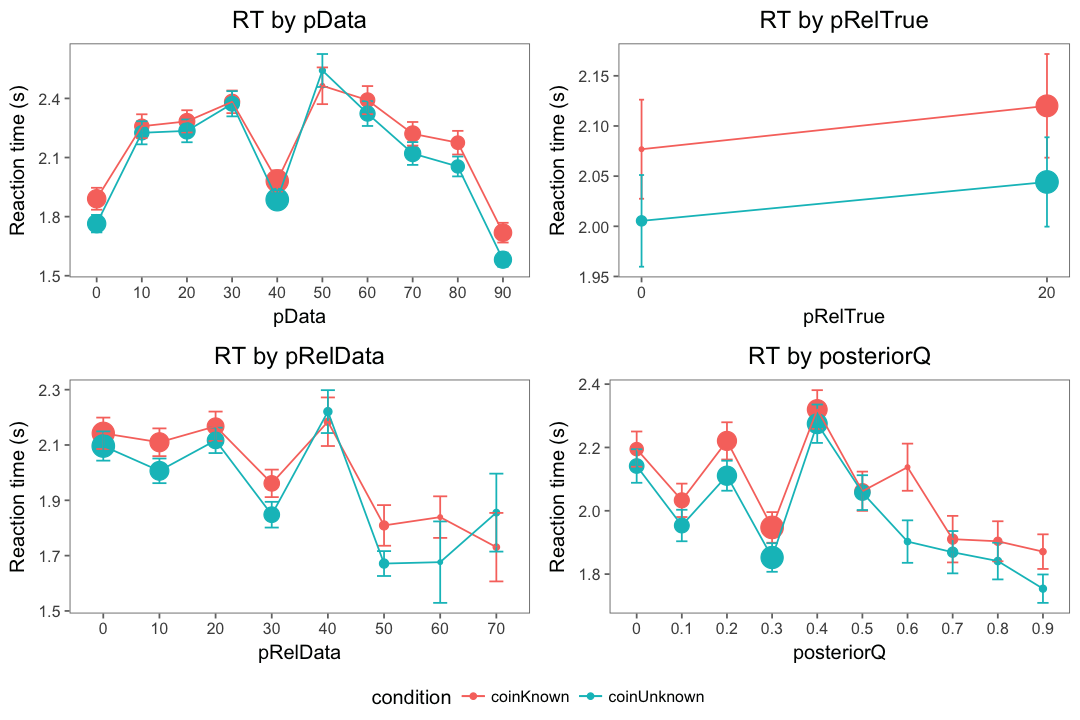

In [740]:
# Visualize RT by experimental design features: pData, pRelData, pRelTrue, posteriorQ

options(repr.plot.width = 9, repr.plot.height = 6)

# By pData:
data %>% select(subjectID, condition, pData, RT) %>%
    group_by(subjectID, condition, pData.bin = cut_interval(pData, 10)) %>%
    summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n()), count = n()) %>%
    ungroup() %>%
    group_by(condition, pData.bin) %>%
    summarise(mean.RT.pData = mean(mean.RT), se.RT.pData = sd(mean.RT) / sqrt(n()), count.group = mean(count)) %>%
    ggplot() + geom_point(aes(x = pData.bin, y = mean.RT.pData, color = condition, size = count.group)) +
    geom_errorbar(aes(x = pData.bin, ymin = mean.RT.pData - se.RT.pData, ymax = mean.RT.pData + se.RT.pData, color = condition), width = .25) +
    geom_line(aes(x = pData.bin, y = mean.RT.pData, group = condition, color = condition)) +
    scale_x_discrete(labels = seq(0, 100, 10)) +
    #scale_y_continuous(limits = c(1.75, 2.25)) +
    labs(title = "RT by pData", y = "Reaction time (s)", x = "pData") +
    ggthemes::theme_few() + guides(size = FALSE) +
    theme(plot.title = element_text(hjust = 0.5)) -> RT.bypData.plot

# By pRelData
data %>% select(subjectID, condition, pRelData, RT) %>%
    group_by(subjectID, condition, pRelData.bin = cut_interval(pRelData, 8)) %>%
    summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n()), count = n()) %>%
    ungroup() %>%
    group_by(condition, pRelData.bin) %>%
    summarise(mean.RT.pRelData = mean(mean.RT), se.RT.pRelData = sd(mean.RT) / sqrt(n()), count.group = mean(count)) %>%
    ggplot() + geom_point(aes(x = pRelData.bin, y = mean.RT.pRelData, color = condition, size = count.group)) +
    geom_errorbar(aes(x = pRelData.bin, ymin = mean.RT.pRelData - se.RT.pRelData, ymax = mean.RT.pRelData + se.RT.pRelData, color = condition), width = .25) +
    geom_line(aes(x = pRelData.bin, y = mean.RT.pRelData, group = condition, color = condition)) +
    scale_x_discrete(labels = seq(0, 80, 10)) +
    #scale_y_continuous(limits = c(1.75, 2.25)) +
    labs(title = "RT by pRelData", y = "Reaction time (s)", x = "pRelData") +
    ggthemes::theme_few() + guides(size = FALSE) +
    theme(plot.title = element_text(hjust = 0.5)) -> RT.bypRelData.plot

# By pRelTrue
data %>% select(subjectID, condition, pRelTrue, RT) %>%
    group_by(subjectID, condition, pRelTrue) %>%
    summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n()), count = n()) %>%
    ungroup() %>%
    group_by(condition, pRelTrue) %>%
    summarise(mean.RT.pRelTrue = mean(mean.RT), se.RT.pRelTrue = sd(mean.RT) / sqrt(n()), count.group = mean(count)) %>%
    ggplot() + geom_point(aes(x = pRelTrue, y = mean.RT.pRelTrue, color = condition, size = count.group)) +
    geom_errorbar(aes(x = pRelTrue, ymin = mean.RT.pRelTrue - se.RT.pRelTrue, ymax = mean.RT.pRelTrue + se.RT.pRelTrue, color = condition), width = .25) +
    geom_line(aes(x = pRelTrue, y = mean.RT.pRelTrue, group = condition, color = condition)) +
    scale_x_continuous(breaks = c(0, 20), labels = c(0, 20)) +
    labs(title = "RT by pRelTrue", y = "Reaction time (s)", x = "pRelTrue") +
    ggthemes::theme_few() + guides(size = FALSE) +
    theme(plot.title = element_text(hjust = 0.5)) -> RT.bypRelTrue.plot

# By posteriorQ
data %>% select(subjectID, condition, posteriorQ, RT) %>%
    group_by(subjectID, condition, posteriorQ.bin = cut_interval(posteriorQ, 10)) %>%
    summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n()), count = n()) %>%
    ungroup() %>%
    group_by(condition, posteriorQ.bin) %>%
    summarise(mean.RT.posteriorQ = mean(mean.RT), se.RT.posteriorQ = sd(mean.RT) / sqrt(n()), count.group = mean(count)) %>%
    ggplot() + geom_point(aes(x = posteriorQ.bin, y = mean.RT.posteriorQ, color = condition, size = count.group)) +
    geom_errorbar(aes(x = posteriorQ.bin, ymin = mean.RT.posteriorQ - se.RT.posteriorQ, ymax = mean.RT.posteriorQ + se.RT.posteriorQ, color = condition), width = .25) +
    geom_line(aes(x = posteriorQ.bin, y = mean.RT.posteriorQ, group = condition, color = condition)) +
    scale_x_discrete(labels = round(seq(0, 1, 1/10), 2)) +
    #scale_y_continuous(limits = c(1.75, 2.25)) +
    labs(title = "RT by posteriorQ", y = "Reaction time (s)", x = "posteriorQ") +
    ggthemes::theme_few() + guides(size = FALSE) +
    theme(plot.title = element_text(hjust = 0.5)) -> RT.byposteriorQ.plot 

grid_arrange_shared_legend(RT.bypData.plot, RT.bypRelTrue.plot, RT.bypRelData.plot, RT.byposteriorQ.plot, nrow = 2, ncol = 2, position = "bottom")


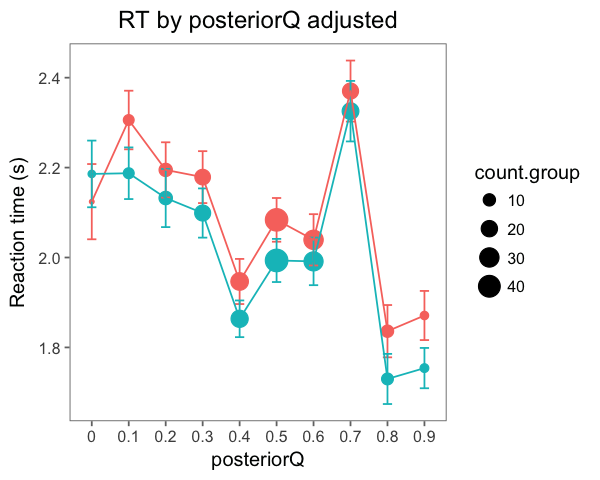

In [695]:
# Visualize RT by adjusted posteriorQ

options(repr.plot.width = 5, repr.plot.height = 4)

data %>% select(subjectID, condition, posteriorQ.adjusted, RT) %>%
         group_by(subjectID, condition, posteriorQ.adjusted.bin = cut_interval(posteriorQ.adjusted, 10)) %>%
         summarise(mean.RT = mean(RT, na.rm = TRUE), se.RT = sd(RT, na.rm = TRUE) / sqrt(n()), count = n()) %>%
         ungroup() %>%
         group_by(condition, posteriorQ.adjusted.bin) %>%
         summarise(mean.RT.posteriorQ.adjusted = mean(mean.RT), se.RT.posteriorQ.adjusted = sd(mean.RT) / sqrt(n()), count.group = mean(count)) %>%
         ggplot() + geom_point(aes(x = posteriorQ.adjusted.bin, y = mean.RT.posteriorQ.adjusted, color = condition, size = count.group)) +
         geom_errorbar(aes(x = posteriorQ.adjusted.bin, ymin = mean.RT.posteriorQ.adjusted - se.RT.posteriorQ.adjusted, ymax = mean.RT.posteriorQ.adjusted + se.RT.posteriorQ.adjusted, color = condition), width = .25) +
         geom_line(aes(x = posteriorQ.adjusted.bin, y = mean.RT.posteriorQ.adjusted, group = condition, color = condition)) +
         scale_x_discrete(labels = round(seq(0, 1, 1/10), 2)) +
         #scale_y_continuous(limits = c(1.75, 2.25)) +
         labs(title = "RT by posteriorQ adjusted", y = "Reaction time (s)", x = "posteriorQ") +
         ggthemes::theme_few() + guides(color = FALSE) +
         theme(plot.title = element_text(hjust = 0.5))

## 6. Visualize behavioral data: Choices

In [777]:
# Display proportion of choices by condition
round(prop.table(table(data$choice, data$condition)), 2)

# Display proportion of choices by congruence
round(prop.table(table(data$choice, data$cong)), 2)

# Display proportion of choices by absolute session number
round(prop.table(table(data$choice, data$totSession)), 2)

     
      coinKnown coinUnknown
  no       0.22        0.23
  yes      0.27        0.28

     
      incongruent congruent
  no         0.28      0.17
  yes        0.25      0.30

     
         1    2    3    4    5    6
  no  0.07 0.07 0.08 0.08 0.07 0.07
  yes 0.09 0.09 0.09 0.09 0.09 0.09

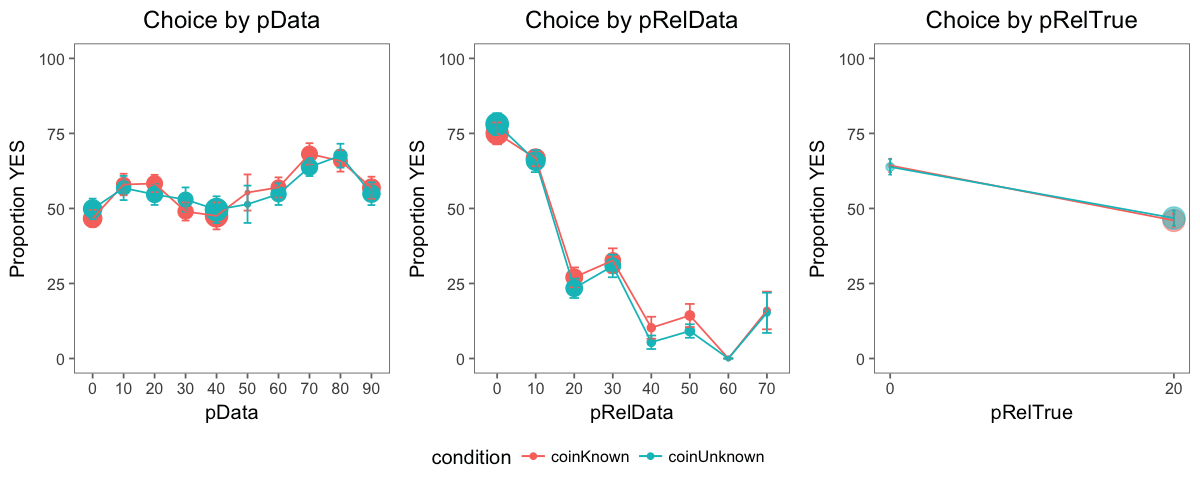

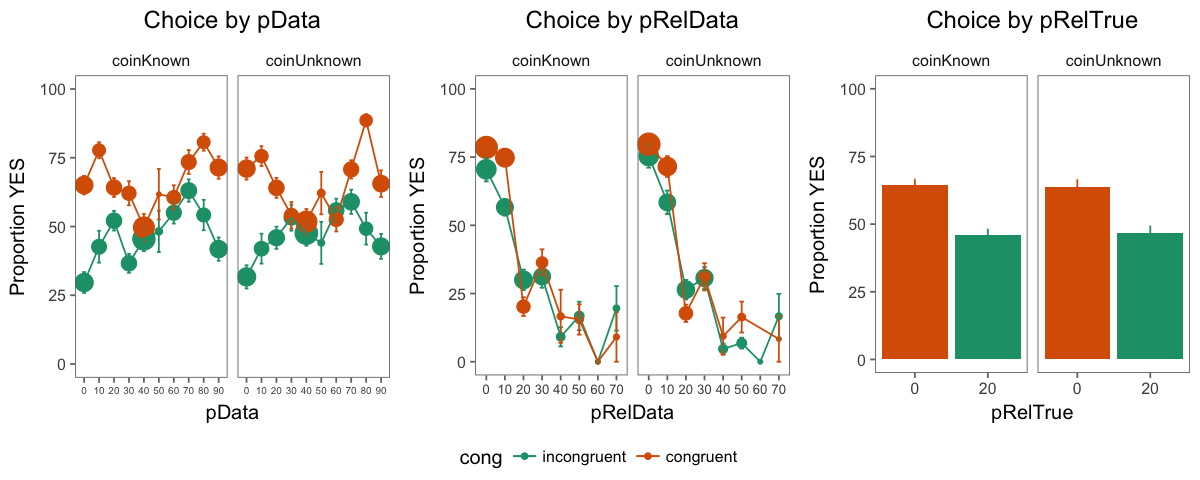

In [637]:
# Visualize choice data by pData, pRelData, and pRelTrue
# Compute and visualize proportion of YES choices as a function of experimental features of interest

options(repr.plot.width = 10, repr.plot.height = 4, warn = 0)

# By Condition:

# By pData
choice.by.pData <- data %>% select(subjectID, condition, pData, choice) %>%
                            group_by(subjectID, condition, pData.bin = cut_interval(pData, 10)) %>%
                            summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
                            ungroup() %>%
                            group_by(condition, pData.bin) %>%
                            summarise(mean.prop.YES.pData = mean(prop.YES), se.prop.YES.pData = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
                            ggplot() + geom_point(aes(x = pData.bin, y = mean.prop.YES.pData, color = condition, size = avg.count)) +
                            geom_errorbar(aes(x = pData.bin, ymin = mean.prop.YES.pData - se.prop.YES.pData, ymax = mean.prop.YES.pData + se.prop.YES.pData, color = condition), width = .25) +
                            geom_line(aes(x = pData.bin, y = mean.prop.YES.pData, group = condition, color = condition)) +
                            scale_x_discrete(labels = seq(0, 100, 10)) +
                            scale_y_continuous(limits = c(0, 100)) +
                            labs(title = "Choice by pData", y = "Proportion YES", x = "pData") +
                            ggthemes::theme_few() + guides(size = FALSE) +
                            theme(plot.title = element_text(hjust = 0.5))

# By pRelData
choice.by.pRelData <- data %>% select(subjectID, condition, pRelData, choice) %>%
                              group_by(subjectID, condition, pRelData.bin = cut_interval(pRelData, 8)) %>%
                              summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
                              ungroup() %>%
                              group_by(condition, pRelData.bin) %>%
                              summarise(mean.prop.YES.pRelData = mean(prop.YES), se.prop.YES.pRelData = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
                              ggplot() + geom_point(aes(x = pRelData.bin, y = mean.prop.YES.pRelData, color = condition, size = avg.count)) +
                              geom_errorbar(aes(x = pRelData.bin, ymin = mean.prop.YES.pRelData - se.prop.YES.pRelData, ymax = mean.prop.YES.pRelData + se.prop.YES.pRelData, color = condition), width = .25) +
                              geom_line(aes(x = pRelData.bin, y = mean.prop.YES.pRelData, group = condition, color = condition)) +
                              scale_x_discrete(labels = seq(0, 80, 10)) +
                              scale_y_continuous(limits = c(0, 100)) +
                              labs(title = "Choice by pRelData", y = "Proportion YES", x = "pRelData") +
                              ggthemes::theme_few() + guides(size = FALSE) +
                              theme(plot.title = element_text(hjust = 0.5))

# By pRelTrue
choice.by.pRelTrue <- data %>% select(subjectID, condition, pRelTrue, choice) %>%
                              group_by(subjectID, condition, pRelTrue) %>%
                              summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
                              ungroup() %>%
                              group_by(condition, pRelTrue) %>%
                              summarise(mean.prop.YES.pRelTrue = mean(prop.YES), se.prop.YES.pRelTrue = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
                              ggplot() + geom_point(aes(x = pRelTrue, y = mean.prop.YES.pRelTrue, color = condition, size = avg.count), alpha = 0.5) +
                              geom_errorbar(aes(x = pRelTrue, ymin = mean.prop.YES.pRelTrue - se.prop.YES.pRelTrue, ymax = mean.prop.YES.pRelTrue + se.prop.YES.pRelTrue, color = condition), width = .25) +
                              geom_line(aes(x = pRelTrue, y = mean.prop.YES.pRelTrue, group = condition, color = condition)) +
                              scale_x_continuous(breaks = seq(0, 20, 20), labels = seq(0, 20, 20)) +
                              scale_y_continuous(limits = c(0, 100)) +
                              labs(title = "Choice by pRelTrue", y = "Proportion YES", x = "pRelTrue") +
                              ggthemes::theme_few() + guides(size = FALSE) +
                              theme(plot.title = element_text(hjust = 0.5))

# By Condition and Congruence:

# By pData
choice.by.pData.bycong <- data %>% select(subjectID, condition, cong, pData, choice) %>%
                                   group_by(subjectID, condition, cong, pData.bin = cut_interval(pData, 10)) %>%
                                   summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
                                   ungroup() %>%
                                   group_by(condition, cong, pData.bin) %>%
                                   summarise(mean.prop.YES.pData = mean(prop.YES), se.prop.YES.pData = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
                                   ggplot() + geom_point(aes(x = pData.bin, y = mean.prop.YES.pData, color = cong, size = avg.count)) +
                                   geom_errorbar(aes(x = pData.bin, ymin = mean.prop.YES.pData - se.prop.YES.pData, ymax = mean.prop.YES.pData + se.prop.YES.pData, color = cong), width = .25) +
                                   geom_line(aes(x = pData.bin, y = mean.prop.YES.pData, group = cong, color = cong)) +
                                   scale_x_discrete(labels = seq(0, 100, 10)) +
                                   scale_y_continuous(limits = c(0, 100)) +
                                   scale_color_brewer(palette = "Dark2") +
                                   labs(title = "Choice by pData", y = "Proportion YES", x = "pData") +
                                   facet_grid(. ~ condition) +
                                   ggthemes::theme_few() + guides(size = FALSE) +
                                   theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(size = 6))

# By pRelData
choice.by.pRelData.bycong <- data %>% select(subjectID, condition, cong, pRelData, choice) %>%
                                      group_by(subjectID, condition, cong, pRelData.bin = cut_interval(pRelData, 8)) %>%
                                      summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
                                      ungroup() %>%
                                      group_by(condition, cong, pRelData.bin) %>%
                                      summarise(mean.prop.YES.pRelData = mean(prop.YES), se.prop.YES.pRelData = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
                                      ggplot() + geom_point(aes(x = pRelData.bin, y = mean.prop.YES.pRelData, color = cong, size = avg.count)) +
                                      geom_errorbar(aes(x = pRelData.bin, ymin = mean.prop.YES.pRelData - se.prop.YES.pRelData, ymax = mean.prop.YES.pRelData + se.prop.YES.pRelData, color = cong), width = .25, na.rm = TRUE) +
                                      geom_line(aes(x = pRelData.bin, y = mean.prop.YES.pRelData, group = cong, color = cong)) +
                                      scale_x_discrete(labels = seq(0, 80, 10)) +
                                      scale_y_continuous(limits = c(0, 100)) +
                                      scale_color_brewer(palette = "Dark2") +
                                      labs(title = "Choice by pRelData", y = "Proportion YES", x = "pRelData") +
                                      facet_grid(. ~ condition) +
                                      ggthemes::theme_few() + guides(size = FALSE) +
                                      theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(size = 8))

# By pRelTrue
choice.by.pRelTrue.bycong <- data %>% select(subjectID, condition, cong, pRelTrue, choice) %>%
                                      group_by(subjectID, condition, cong, pRelTrue) %>%
                                      summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
                                      ungroup() %>%
                                      group_by(condition, cong, pRelTrue) %>%
                                      summarise(mean.prop.YES.pRelTrue = mean(prop.YES), se.prop.YES.pRelTrue = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
                                      ggplot() + geom_bar(aes(x = pRelTrue, y = mean.prop.YES.pRelTrue, fill = cong), stat = "identity") +
                                      geom_errorbar(aes(x = pRelTrue, ymin = mean.prop.YES.pRelTrue - se.prop.YES.pRelTrue, ymax = mean.prop.YES.pRelTrue + se.prop.YES.pRelTrue, color = cong), width = .25, na.rm = TRUE) +
                                      scale_x_continuous(breaks = seq(0, 20, 20), labels = seq(0, 20, 20)) +
                                      scale_y_continuous(limits = c(0, 100)) +
                                      scale_fill_brewer(palette = "Dark2") +
                                      scale_color_brewer(palette = "Dark2") +
                                      labs(title = "Choice by pRelTrue", y = "Proportion YES", x = "pRelTrue") +
                                      facet_grid(. ~ condition) +
                                      ggthemes::theme_few() + guides(fill = FALSE, size = FALSE) +
                                      theme(plot.title = element_text(hjust = 0.5))

grid_arrange_shared_legend(choice.by.pData, choice.by.pRelData, choice.by.pRelTrue, nrow = 1, ncol = 3, position = "bottom")

grid_arrange_shared_legend(choice.by.pData.bycong, choice.by.pRelData.bycong, choice.by.pRelTrue.bycong, nrow = 1, ncol = 3, position = "bottom")


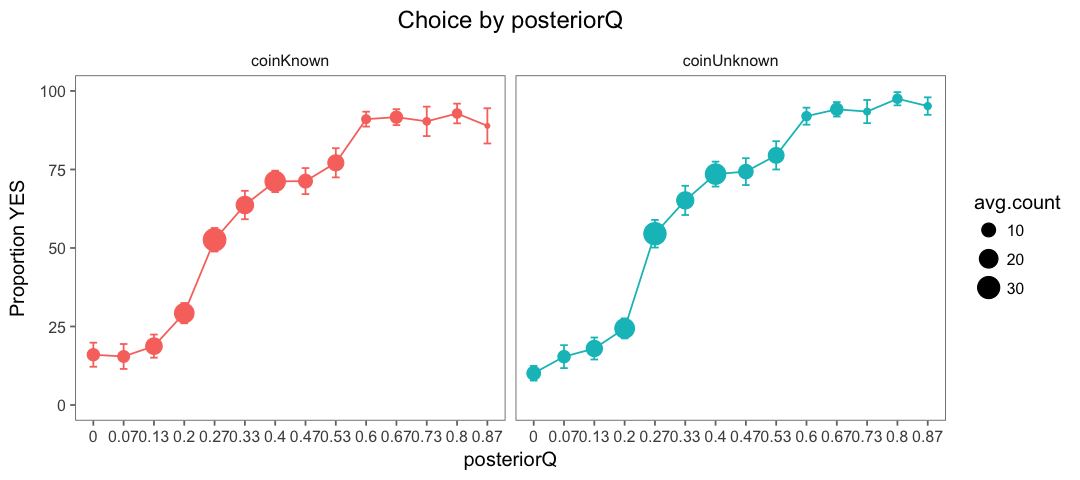

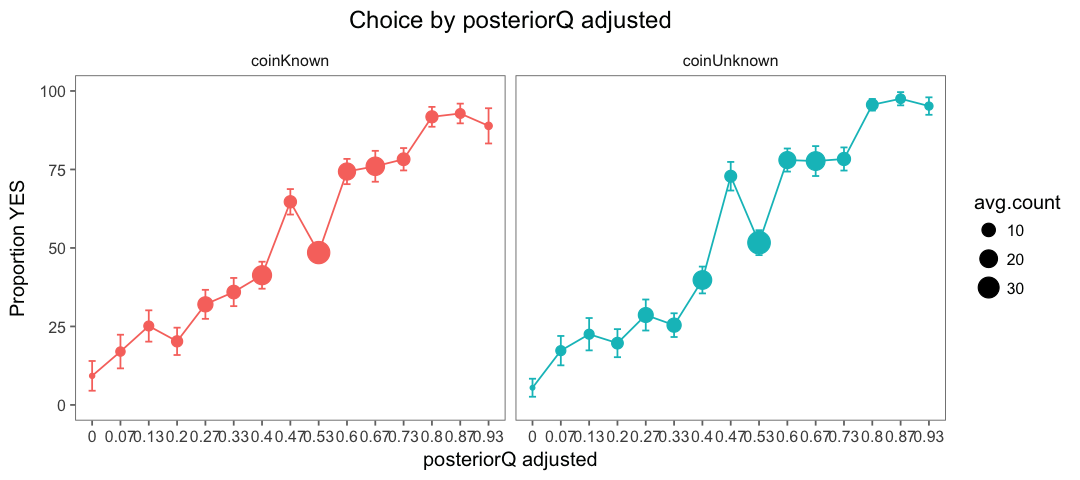

In [664]:
# Visualize choice data by posterior probability of question

# By condition:

options(repr.plot.width = 9, repr.plot.height = 4)

# Compute and visualize proportion of YES choice as a function of the posterior probability of the question coin
data %>% select(subjectID, condition, posteriorQ, choice) %>%
    group_by(subjectID, condition, posteriorQ.bin = cut_interval(posteriorQ, 15)) %>%
    summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
    ungroup() %>%
    group_by(condition, posteriorQ.bin) %>%
    summarise(mean.prop.YES.posteriorQ = mean(prop.YES), se.prop.YES.posteriorQ = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
    ggplot() + geom_point(aes(x = posteriorQ.bin, y = mean.prop.YES.posteriorQ, color = condition, size = avg.count)) +
    geom_errorbar(aes(x = posteriorQ.bin, ymin = mean.prop.YES.posteriorQ - se.prop.YES.posteriorQ, ymax = mean.prop.YES.posteriorQ + se.prop.YES.posteriorQ, color = condition), width = .25) +
    geom_line(aes(x = posteriorQ.bin, y = mean.prop.YES.posteriorQ, group = condition, color = condition)) +
    scale_x_discrete(labels = round(seq(0, 1, 1/15), 2)) +
    scale_y_continuous(limits = c(0, 100)) +
    facet_grid(. ~ condition) +
    labs(title = "Choice by posteriorQ", y = "Proportion YES", x = "posteriorQ") +
    ggthemes::theme_few() + guides(color = FALSE) +
    theme(plot.title = element_text(hjust = 0.5))

# Using adjusted posteriorQ
data %>% select(subjectID, condition, posteriorQ.adjusted, choice) %>%
    group_by(subjectID, condition, posteriorQ.adjusted.bin = cut_interval(posteriorQ.adjusted, 15)) %>%
    summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
    ungroup() %>%
    group_by(condition, posteriorQ.adjusted.bin) %>%
    summarise(mean.prop.YES.posteriorQ.adjusted = mean(prop.YES), se.prop.YES.posteriorQ.adjusted = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
    ggplot() + geom_point(aes(x = posteriorQ.adjusted.bin, y = mean.prop.YES.posteriorQ.adjusted, color = condition, size = avg.count)) +
    geom_errorbar(aes(x = posteriorQ.adjusted.bin, ymin = mean.prop.YES.posteriorQ.adjusted - se.prop.YES.posteriorQ.adjusted, ymax = mean.prop.YES.posteriorQ.adjusted + se.prop.YES.posteriorQ.adjusted, color = condition), width = .25) +
    geom_line(aes(x = posteriorQ.adjusted.bin, y = mean.prop.YES.posteriorQ.adjusted, group = condition, color = condition)) +
    scale_x_discrete(labels = round(seq(0, 1, 1/15), 2)) +
    scale_y_continuous(limits = c(0, 100)) +
    facet_grid(. ~ condition) +
    labs(title = "Choice by posteriorQ adjusted", y = "Proportion YES", x = "posteriorQ adjusted") +
    ggthemes::theme_few() + guides(color = FALSE) +
    theme(plot.title = element_text(hjust = 0.5))

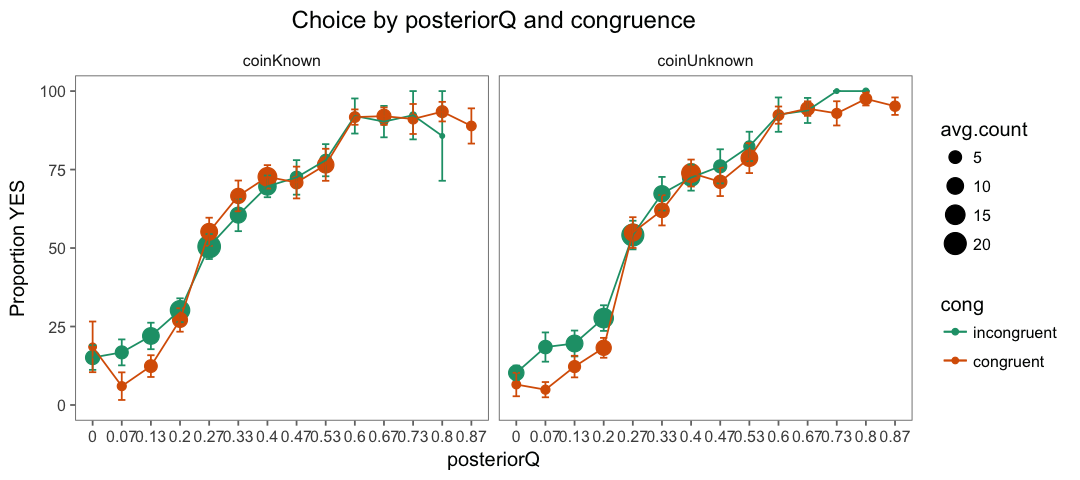

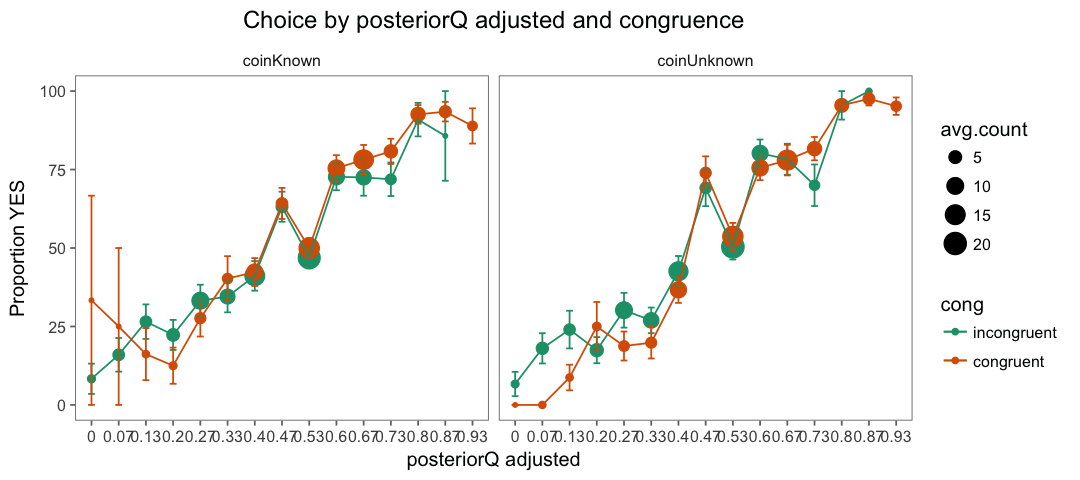

In [665]:
# Visualize choice data by posterior probability of question

# By condition and congruence:

options(repr.plot.width = 9, repr.plot.height = 4)

# Compute and visualize proportion of YES choice as a function of the posterior probability of the question coin
# Separately for each condition and each level of the congruence factor (congruent, incongruent)
data %>% select(subjectID, condition, cong, posteriorQ, choice) %>%
    group_by(subjectID, condition, cong, posteriorQ.bin = cut_interval(posteriorQ, 15)) %>%
    summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
    ungroup() %>%
    group_by(condition, cong, posteriorQ.bin) %>%
    summarise(mean.prop.YES.posteriorQ = mean(prop.YES), se.prop.YES.posteriorQ = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
    ggplot() + geom_point(aes(x = posteriorQ.bin, y = mean.prop.YES.posteriorQ, color = cong, size = avg.count)) +
    geom_errorbar(aes(x = posteriorQ.bin, ymin = mean.prop.YES.posteriorQ - se.prop.YES.posteriorQ, ymax = mean.prop.YES.posteriorQ + se.prop.YES.posteriorQ, color = cong), width = .25, na.rm = TRUE) +
    geom_line(aes(x = posteriorQ.bin, y = mean.prop.YES.posteriorQ, group = cong, color = cong)) +
    scale_color_brewer(palette = "Dark2") +
    scale_x_discrete(labels = round(seq(0, 1, 1/15), 2)) +
    scale_y_continuous(limits = c(0, 100)) +
    facet_grid(. ~ condition) +
    labs(title = "Choice by posteriorQ and congruence", y = "Proportion YES", x = "posteriorQ") +
    ggthemes::theme_few() +
    theme(plot.title = element_text(hjust = 0.5))

# Using adjusted posteriorQ
data %>% select(subjectID, condition, cong, posteriorQ.adjusted, choice) %>%
    group_by(subjectID, condition, cong, posteriorQ.adjusted.bin = cut_interval(posteriorQ.adjusted, 15)) %>%
    summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100, count = n()) %>%
    ungroup() %>%
    group_by(condition, cong, posteriorQ.adjusted.bin) %>%
    summarise(mean.prop.YES.posteriorQ.adjusted = mean(prop.YES), se.prop.YES.posteriorQ.adjusted = sd(prop.YES) / sqrt(n()), avg.count = mean(count)) %>%
    ggplot() + geom_point(aes(x = posteriorQ.adjusted.bin, y = mean.prop.YES.posteriorQ.adjusted, color = cong, size = avg.count)) +
    geom_errorbar(aes(x = posteriorQ.adjusted.bin, ymin = mean.prop.YES.posteriorQ.adjusted - se.prop.YES.posteriorQ.adjusted, ymax = mean.prop.YES.posteriorQ.adjusted + se.prop.YES.posteriorQ.adjusted, color = cong), width = .25, na.rm = TRUE) +
    geom_line(aes(x = posteriorQ.adjusted.bin, y = mean.prop.YES.posteriorQ.adjusted, group = cong, color = cong)) +
    scale_color_brewer(palette = "Dark2") +
    scale_x_discrete(labels = round(seq(0, 1, 1/15), 2)) +
    scale_y_continuous(limits = c(0, 100)) +
    facet_grid(. ~ condition) +
    labs(title = "Choice by posteriorQ adjusted and congruence", y = "Proportion YES", x = "posteriorQ adjusted") +
    ggthemes::theme_few() +
    theme(plot.title = element_text(hjust = 0.5))

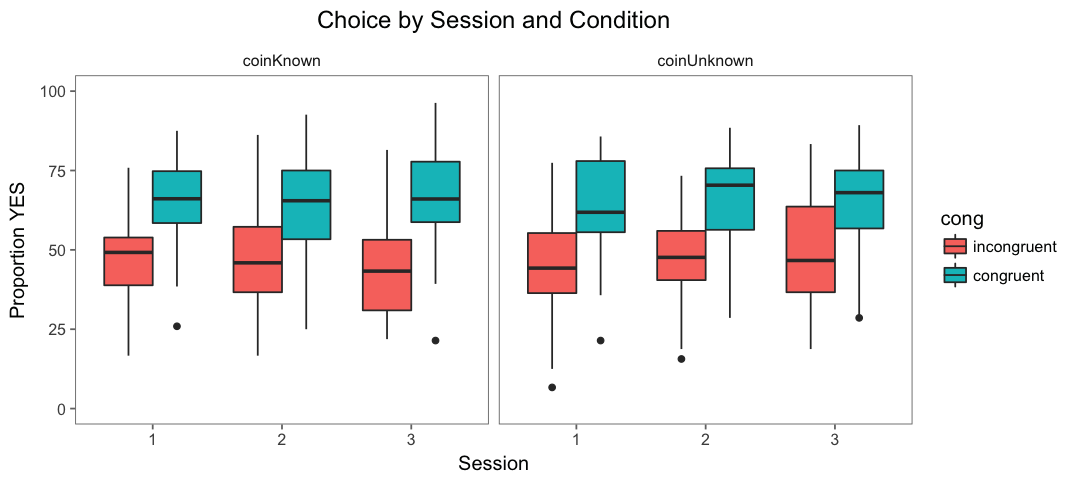

In [757]:
# For control purposes, visualize proportion of YES choices for each session and condition separately
# Separate measure by congruence level

options(repr.plot.width = 9, repr.plot.height = 4)

choice.by.session <- data %>% select(subjectID, condition, condSession, cong, choice) %>%
                              group_by(subjectID, condition, cong, condSession) %>%
                              summarise(prop.YES = sum(as.numeric(choice) - 1) / n() * 100) %>%
                              ggplot() + geom_boxplot(aes(x = condSession, y = prop.YES, fill = cong)) +
                              scale_y_continuous(limits = c(0, 100)) +
                              scale_color_brewer(palette = "Dark2") +
                              labs(title = "Choice by Session and Condition", y = "Proportion YES", x = "Session") +
                              facet_grid(. ~ condition) +
                              ggthemes::theme_few() +
                              theme(plot.title = element_text(hjust = 0.5))

choice.by.session

## 7. Visualize behavioral data: Choice accuracy

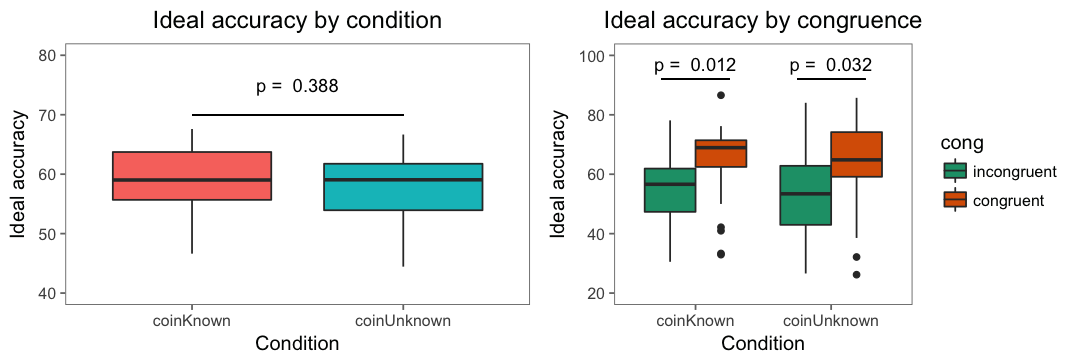

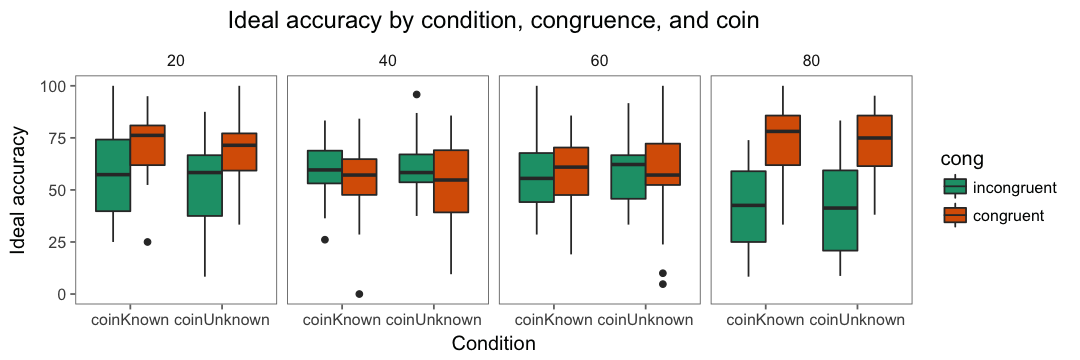

In [641]:
# Compute and visualize "ideal" choice accuracy for each condition, congruence level, and question coin
# Accuracy computed with respect to ideal agent who chooses "yes" for congruent trials and "no" for incongruent trials

# Calculate "ideal" choice accuracies

# By condition
accuracy.by.condition <- data %>% select(subjectID, condition, cong, choice) %>%
                                  mutate(correct = ifelse((cong == "congruent" & choice == "yes") | (cong == "incongruent" & choice == "no"), 1, 0)) %>%
                                  group_by(subjectID, condition) %>%                                 
                                  summarise(accuracy = sum(correct) / n() * 100)

# By condition: Statistical test
x <- accuracy.by.condition$accuracy[accuracy.by.condition$condition == "coinKnown"]
y <- accuracy.by.condition$accuracy[accuracy.by.condition$condition == "coinUnknown"]

accuracy.bycondition.test <- t.test(x, y, paired = TRUE)

# By condition and congruence
accuracy.by.condition.cong <- data %>% select(subjectID, condition, cong, choice) %>%
                                       mutate(correct = ifelse((cong == "congruent" & choice == "yes") | (cong == "incongruent" & choice == "no"), 1, 0)) %>%
                                       group_by(subjectID, condition, cong) %>%                                 
                                       summarise(accuracy = sum(correct) / n() * 100)

# By condition and congruence: Statistical tests
x <- accuracy.by.condition.cong$accuracy[accuracy.by.condition.cong$condition == "coinKnown" & accuracy.by.condition.cong$cong == "congruent"]
y <- accuracy.by.condition.cong$accuracy[accuracy.by.condition.cong$condition == "coinKnown" & accuracy.by.condition.cong$cong == "incongruent"]

accuracy.bycong.coinKnown.test <- t.test(x, y, paired = TRUE)

x <- accuracy.by.condition.cong$accuracy[accuracy.by.condition.cong$condition == "coinUnknown" & accuracy.by.condition.cong$cong == "congruent"]
y <- accuracy.by.condition.cong$accuracy[accuracy.by.condition.cong$condition == "coinUnknown" & accuracy.by.condition.cong$cong == "incongruent"]

accuracy.bycong.coinUnknown.test <- t.test(x, y, paired = TRUE)

# By condition, congruence, and coin
accuracy.by.condition.cong.coin <- data %>% select(subjectID, condition, cong, choice, trueCoin) %>%
                                            mutate(correct = ifelse((cong == "congruent" & choice == "yes") | (cong == "incongruent" & choice == "no"), 1, 0)) %>%
                                            group_by(subjectID, condition, cong, trueCoin) %>%                                 
                                            summarise(accuracy = sum(correct) / n() * 100)

# Visualize "ideal" choice accuracies

# By condition plot
accuracy.by.condition.plot <- accuracy.by.condition %>%
                              ggplot(aes(x = condition, y = accuracy, fill = condition)) +
                              geom_boxplot() +
                              geom_segment(aes(x = 1, xend = 2, y = 70, yend = 70), lwd = 0.25) +
                              annotate(geom = "text", x = 1.5, y = 75, hjust = 0.5,
                                       label = paste("p = ", round(accuracy.bycondition.test$p.value, 3)),
                                       color = "black") +
                              scale_y_continuous(limits = c(40, 80)) +
                              guides(fill = FALSE) +
                              labs(title = "Ideal accuracy by condition", y = "Ideal accuracy", x = "Condition") +
                              ggthemes::theme_few() +
                              theme(plot.title = element_text(hjust = 0.5))

# By condition and congruence plot
accuracy.by.condition.cong.plot <- accuracy.by.condition.cong %>%
                                   ggplot(aes(x = condition, y = accuracy, fill = cong)) +
                                   geom_boxplot(position = "dodge") +
                                   geom_segment(aes(x = 0.75, xend = 1.25, y = 92, yend = 92), lwd = 0.25) +
                                   annotate(geom = "text", x = 1, y = 97, hjust = 0.5,
                                            label = paste("p = ", round(accuracy.bycong.coinKnown.test$p.value, 3)),
                                            color = "black") +
                                   geom_segment(aes(x = 1.75, xend = 2.25, y = 92, yend = 92), lwd = 0.25) +
                                   annotate(geom = "text", x = 2, y = 97, hjust = 0.5,
                                            label = paste("p = ", round(accuracy.bycong.coinUnknown.test$p.value, 3)),
                                            color = "black") +
                                   scale_y_continuous(limits = c(20, 100)) +
                                   scale_fill_brewer(palette = "Dark2") +
                                   labs(title = "Ideal accuracy by congruence", y = "Ideal accuracy", x = "Condition") +
                                   ggthemes::theme_few() +
                                   theme(plot.title = element_text(hjust = 0.5))
                            

options(repr.plot.width = 9, repr.plot.height = 3)

grid.arrange(accuracy.by.condition.plot, accuracy.by.condition.cong.plot, nrow = 1, ncol = 2)

# By condition, congruence, and trueCoin plot
accuracy.by.condition.cong.coin.plot <- accuracy.by.condition.cong.coin %>%
                                        ggplot(aes(x = condition, y = accuracy, fill = cong)) +
                                        geom_boxplot(position = "dodge") +
                                        scale_fill_brewer(palette = "Dark2") +
                                        facet_grid(. ~ trueCoin) +
                                        labs(title = "Ideal accuracy by condition, congruence, and coin", y = "Ideal accuracy", x = "Condition") +
                                        ggthemes::theme_few() +
                                        theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 9, repr.plot.height = 3)

accuracy.by.condition.cong.coin.plot


In [642]:
# Compute and visualize choice accuracy based on pilot data for each condition, congruence level, and question coin
# Accuracy computed with respect to participants who took part in the pilot study (N = 10).

# Load pilot dataset

pilot.data <- read.csv("pilot_data.csv", header = TRUE, stringsAsFactors = FALSE)

head(pilot.data)

# Rename variables to establish consistency with main dataset

pilot.data <- pilot.data %>% rename(subjectID = subject, trialID = trial, trueCoin = pTrue, seqLength = nCoins,
                                    nHeads = nHeads, condition = coinKnown, questionCoin = pQuestion,
                                    choice = choice, RT = rt)

# Remove missed trials (coded as RT = 0, choice = NA)

pilot.data <- pilot.data %>% filter(!(RT == 0))

# Turn condition variable into factor

pilot.data$condition <- factor(pilot.data$condition, levels = c(1, 0), labels = c("coinKnown", "coinUnknown"))

head(pilot.data)

subject,trial,pTrue,nCoins,nHeads,coinKnown,pQuestion,choice,rt
1,1,60,2,1,1,40,1,2.7877
1,2,60,10,4,1,80,0,3.1659
1,3,40,2,0,1,40,1,2.7616
1,4,80,10,6,1,80,0,4.9161
1,5,40,4,0,1,40,0,2.2383
1,6,60,4,2,1,80,0,3.2385


subjectID,trialID,trueCoin,seqLength,nHeads,condition,questionCoin,choice,RT
1,1,60,2,1,coinKnown,40,1,2.7877
1,2,60,10,4,coinKnown,80,0,3.1659
1,3,40,2,0,coinKnown,40,1,2.7616
1,4,80,10,6,coinKnown,80,0,4.9161
1,5,40,4,0,coinKnown,40,0,2.2383
1,6,60,4,2,coinKnown,80,0,3.2385


In [643]:
# Given the pilot data, compute the most frequent choice for each trial combination

pilot.choice.freq <- pilot.data %>% group_by(condition, trueCoin, questionCoin, nHeads, seqLength) %>%
                                    summarise(total_choices = n(), yes_choices = sum(choice), no_choices = n() - yes_choices,
                                              most_freq_choice = ifelse(yes_choices >= no_choices, 1, 0)) %>%
                                    ungroup()

head(pilot.choice.freq)

condition,trueCoin,questionCoin,nHeads,seqLength,total_choices,yes_choices,no_choices,most_freq_choice
coinKnown,20,20,0,2,24,18,6,1
coinKnown,20,20,0,4,22,19,3,1
coinKnown,20,20,0,6,12,11,1,1
coinKnown,20,20,0,8,5,4,1,1
coinKnown,20,20,0,10,2,2,0,1
coinKnown,20,20,1,2,20,2,18,0


In [644]:
# Using the choice table from the pilot data, compute accuracy for each participant and trial combination

return_freq_pilot_choice <- function(pilot.choice.freq, trial.condition, trial.trueCoin,
                                     trial.questionCoin, trial.nHeads, trial.seqLength) {
    
    pilot_choice <- pilot.choice.freq %>% filter(condition == trial.condition,
                                                 trueCoin == trial.trueCoin,
                                                 questionCoin == trial.questionCoin,
                                                 nHeads == trial.nHeads,
                                                 seqLength == trial.seqLength) %>%
                                          select(most_freq_choice)
    
    return(as.numeric(pilot_choice))
    
}

# Add column indicating whether trial choice matched corresponding choice in pilot dataset

for (i in seq(1, nrow(data))) {
    
    pilot_choice <- return_freq_pilot_choice(pilot.choice.freq, data$condition[i], data$trueCoin[i],
                                             data$questionCoin[i], data$nHeads[i], data$seqLength[i])
    
    data$pilotChoice[i] <- pilot_choice
    
}

# When corresponding pilot trial was not found, pilot choice was coded as NA: remove these trials to compute accuracy

data <- data %>% filter(!is.na(pilotChoice))

data$pilotChoice <- factor(data$pilotChoice, levels = c(0, 1), labels = c("no", "yes"))

data <- data %>% mutate(matchPilot = ifelse(choice == pilotChoice, 1, 0))

head(data)

subjectID,trialID,trueCoin,seqLength,nHeads,condition,questionCoin,choice,RT,condSession,totSession,cong,pData,pRelData,pRelTrue,posteriorQ,pilotChoice,matchPilot
1,1,20,4,1,coinKnown,40,yes,3.6776,1,1,incongruent,25,15,20,0.36986301,no,0
1,2,20,4,1,coinKnown,20,yes,2.9792,1,1,congruent,25,5,0,0.43835616,yes,1
1,3,40,2,2,coinKnown,20,no,1.4871,1,1,incongruent,100,80,20,0.03333333,yes,0
1,4,60,2,0,coinKnown,60,no,2.4109,1,1,congruent,0,60,0,0.13333333,no,1
1,5,20,10,0,coinKnown,40,no,2.6895,1,1,incongruent,0,40,20,0.05326208,no,1
1,6,40,8,2,coinKnown,60,no,2.7099,1,1,incongruent,25,35,20,0.07574961,no,1


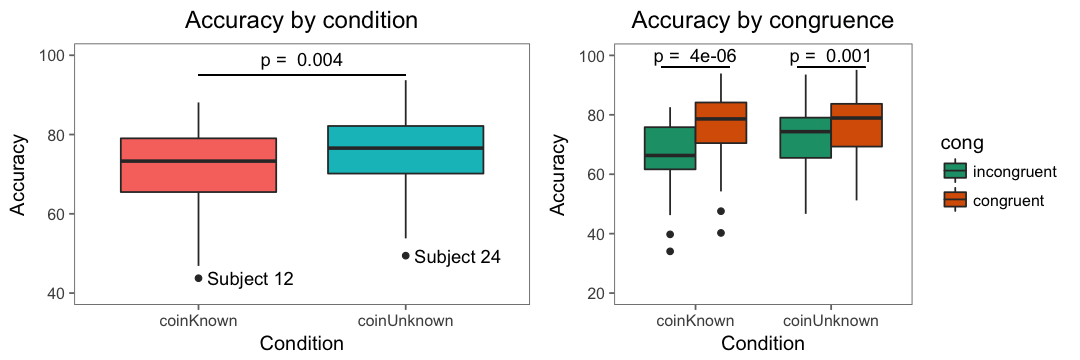

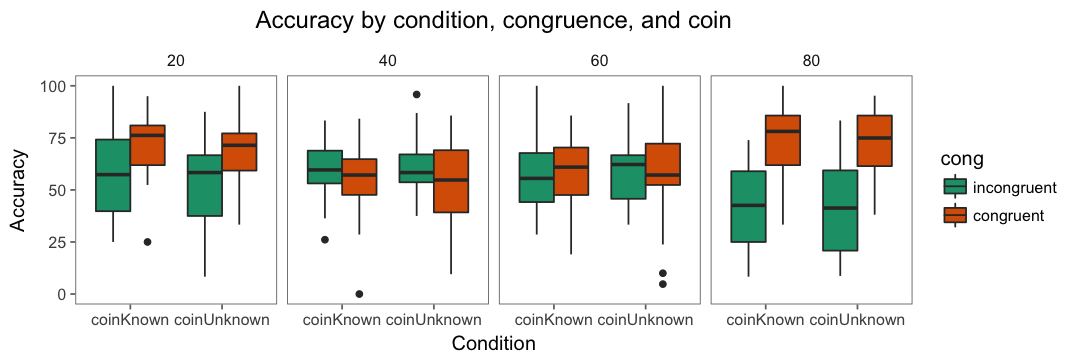

In [645]:
# Compute accuracies by slicing the data 

# Pooled across conditions

accuracy.pooled.wrt.pilot <- data %>% select(subjectID, matchPilot) %>%
                                      group_by(subjectID) %>%                                 
                                      summarise(accuracy = sum(matchPilot) / n() * 100)

# By condition

accuracy.by.condition.wrt.pilot <- data %>% select(subjectID, condition, matchPilot) %>%
                                            group_by(subjectID, condition) %>%                                 
                                            summarise(accuracy = sum(matchPilot) / n() * 100)

accuracy.outliers <- accuracy.by.condition.wrt.pilot %>% ungroup() %>% group_by(condition) %>%
mutate(outlier = (accuracy - quantile(accuracy, 0.25)) < -1.5 * IQR(accuracy)) %>%
                                                         filter(outlier)


x <- accuracy.by.condition.wrt.pilot$accuracy[accuracy.by.condition.wrt.pilot$condition == "coinKnown"]
y <- accuracy.by.condition.wrt.pilot$accuracy[accuracy.by.condition.wrt.pilot$condition == "coinUnknown"]

accuracy.by.condition.wrt.pilot.test <- t.test(x, y, paired = TRUE)

# Build visualization

accuracy.by.condition.wrt.pilot.plot <- accuracy.by.condition.wrt.pilot %>%
                                        ggplot(aes(x = condition, y = accuracy, fill = condition)) +
                                        geom_boxplot() +
                                        geom_segment(aes(x = 1, xend = 2, y = 95, yend = 95), lwd = 0.25) +
                                        geom_text(data = accuracy.outliers, aes(label = paste("Subject", subjectID)), hjust = -0.1) +
                                        annotate(geom = "text", x = 1.5, y = 99, hjust = 0.5,
                                                 label = paste("p = ", round(accuracy.by.condition.wrt.pilot.test$p.value, 3)),
                                                 color = "black") +
                                        scale_y_continuous(limits = c(40, 100)) +
                                        guides(fill = FALSE) +
                                        labs(title = "Accuracy by condition", y = "Accuracy", x = "Condition") +
                                        ggthemes::theme_few() +
                                        theme(plot.title = element_text(hjust = 0.5))

# By condition and congruence

accuracy.by.condition.by.cong.wrt.pilot <- data %>% select(subjectID, condition, cong, matchPilot) %>%
                                                    group_by(subjectID, condition, cong) %>%                                 
                                                    summarise(accuracy = sum(matchPilot) / n() * 100)

x <- accuracy.by.condition.by.cong.wrt.pilot$accuracy[accuracy.by.condition.by.cong.wrt.pilot$condition == "coinKnown" & accuracy.by.condition.by.cong.wrt.pilot$cong == "congruent"]
y <- accuracy.by.condition.by.cong.wrt.pilot$accuracy[accuracy.by.condition.by.cong.wrt.pilot$condition == "coinKnown" & accuracy.by.condition.by.cong.wrt.pilot$cong == "incongruent"]

accuracy.coinKnown.by.cong.wrt.pilot.test <- t.test(x, y, paired = TRUE)

x <- accuracy.by.condition.by.cong.wrt.pilot$accuracy[accuracy.by.condition.by.cong.wrt.pilot$condition == "coinUnknown" & accuracy.by.condition.by.cong.wrt.pilot$cong == "congruent"]
y <- accuracy.by.condition.by.cong.wrt.pilot$accuracy[accuracy.by.condition.by.cong.wrt.pilot$condition == "coinUnknown" & accuracy.by.condition.by.cong.wrt.pilot$cong == "incongruent"]

accuracy.coinUnknown.by.cong.wrt.pilot.test <- t.test(x, y, paired = TRUE)

# Build visualization

accuracy.by.condition.by.cong.wrt.pilot.plot <- accuracy.by.condition.by.cong.wrt.pilot %>%
                                                ggplot(aes(x = condition, y = accuracy, fill = cong)) +
                                                geom_boxplot(position = "dodge") +
                                                geom_segment(aes(x = 0.75, xend = 1.25, y = 96, yend = 96), lwd = 0.25) +
                                                annotate(geom = "text", x = 1, y = 100, hjust = 0.5,
                                                         label = paste("p = ", round(accuracy.coinKnown.by.cong.wrt.pilot.test$p.value, 6)),
                                                         color = "black") +
                                                geom_segment(aes(x = 1.75, xend = 2.25, y = 96, yend = 96), lwd = 0.25) +
                                                annotate(geom = "text", x = 2, y = 100, hjust = 0.5,
                                                         label = paste("p = ", round(accuracy.coinUnknown.by.cong.wrt.pilot.test$p.value, 3)),
                                                         color = "black") +
                                                scale_y_continuous(limits = c(20, 100)) +
                                                scale_fill_brewer(palette = "Dark2") +
                                                labs(title = "Accuracy by congruence", y = "Accuracy", x = "Condition") +
                                                ggthemes::theme_few() +
                                                theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 9, repr.plot.height = 3)

grid.arrange(accuracy.by.condition.wrt.pilot.plot, accuracy.by.condition.by.cong.wrt.pilot.plot, nrow = 1, ncol = 2)

# By condition, congruence, and trueCoin

accuracy.by.condition.by.cong.by.coin.wrt.pilot <- data %>% select(subjectID, condition, cong, trueCoin, matchPilot) %>%
                                                            group_by(subjectID, condition, cong, trueCoin) %>%                                 
                                                            summarise(accuracy = sum(matchPilot) / n() * 100)

# Build visualization

accuracy.by.condition.by.cong.by.coin.wrt.pilot.plot <- accuracy.by.condition.cong.coin %>%
                                                        ggplot(aes(x = condition, y = accuracy, fill = cong)) +
                                                        geom_boxplot(position = "dodge") +
                                                        scale_fill_brewer(palette = "Dark2") +
                                                        facet_grid(. ~ trueCoin) +
                                                        labs(title = "Accuracy by condition, congruence, and coin", y = "Accuracy", x = "Condition") +
                                                        ggthemes::theme_few() +
                                                        theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 9, repr.plot.height = 3)

accuracy.by.condition.by.cong.by.coin.wrt.pilot.plot

                       Df Sum Sq Mean Sq F value Pr(>F)  
condSession             2     53    26.5   0.169 0.8450  
condition               1    681   680.7   4.329 0.0388 *
condSession:condition   2      3     1.6   0.010 0.9898  
Residuals             186  29247   157.2                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

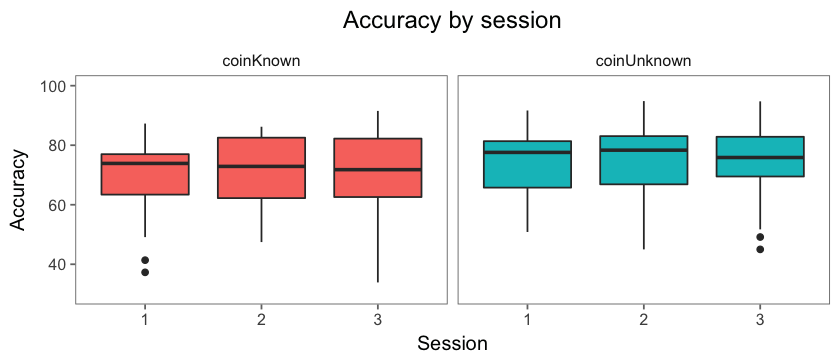

In [752]:
# Plot accuracies (with respect to pilot data) by session for each condition

options(repr.plot.width = 7, repr.plot.height = 3)

accuracy.by.condition.by.session <- data %>% select(subjectID, condition, condSession, matchPilot) %>%
                                             group_by(subjectID, condition, condSession) %>%                                 
                                             summarise(accuracy = sum(matchPilot) / n() * 100) 
                                             
accuracy.by.condition.by.session %>% ggplot(aes(x = condSession, y = accuracy, fill = condition)) +
                                     geom_boxplot() +
                                     facet_grid(. ~ condition) +
                                     scale_y_continuous(limits = c(30, 100)) +
                                     labs(title = "Accuracy by session", y = "Accuracy", x = "Session") +
                                     ggthemes::theme_few() + guides(fill = FALSE) +
                                     theme(plot.title = element_text(hjust = 0.5))

summary(aov(formula = accuracy ~ condSession * condition, data = accuracy.by.condition.by.session))
#TukeyHSD(aov(formula = accuracy ~ condSession * condition, data = accuracy.by.condition.by.session))

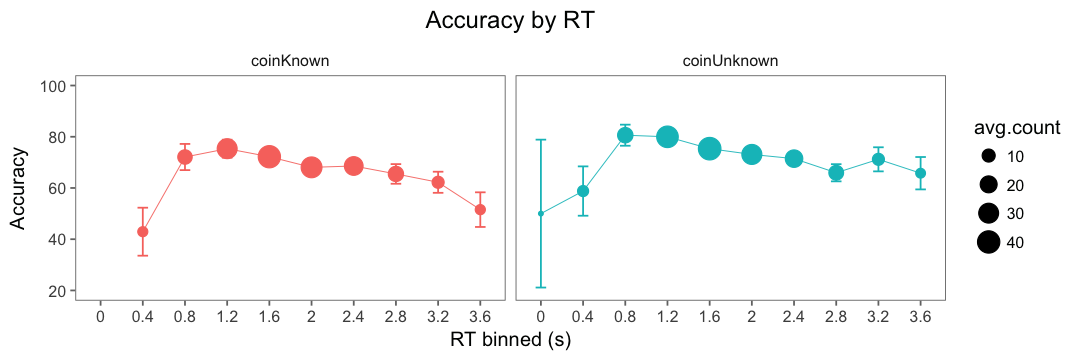

In [647]:
# Plot accuracies by RT for each condition

options(repr.plot.width = 9, repr.plot.height = 3)

data %>% select(subjectID, condition, RT, matchPilot) %>%
         group_by(subjectID, condition, RT.bin = cut_interval(RT, 10)) %>%                                 
         summarise(accuracy = sum(matchPilot) / n() * 100, count = n()) %>%
         ungroup() %>%
         group_by(condition, RT.bin) %>%
         summarise(mean.accuracy.byRT = mean(accuracy), se.accuracy.byRT = sd(accuracy) / sqrt(n()), avg.count = mean(count)) %>%
         ggplot(aes(x = RT.bin, y = mean.accuracy.byRT, color = condition, size = avg.count)) +
         geom_point() +
         geom_errorbar(aes(x = RT.bin, ymin = mean.accuracy.byRT - se.accuracy.byRT, ymax = mean.accuracy.byRT + se.accuracy.byRT, color = condition), width = 0.25, lwd = 0.5, na.rm = TRUE) +
         geom_line(aes(color = condition, group = 1), lwd = 0.25) +
         facet_grid(. ~ condition) +
         scale_x_discrete(labels = round(seq(0, max(data$RT), max(data$RT) / 10), 2)) +
         scale_y_continuous(limits = c(20, 100)) +
         labs(title = "Accuracy by RT", y = "Accuracy", x = "RT binned (s)") +
         ggthemes::theme_few() +
         theme(plot.title = element_text(hjust = 0.5)) + guides(color = FALSE)

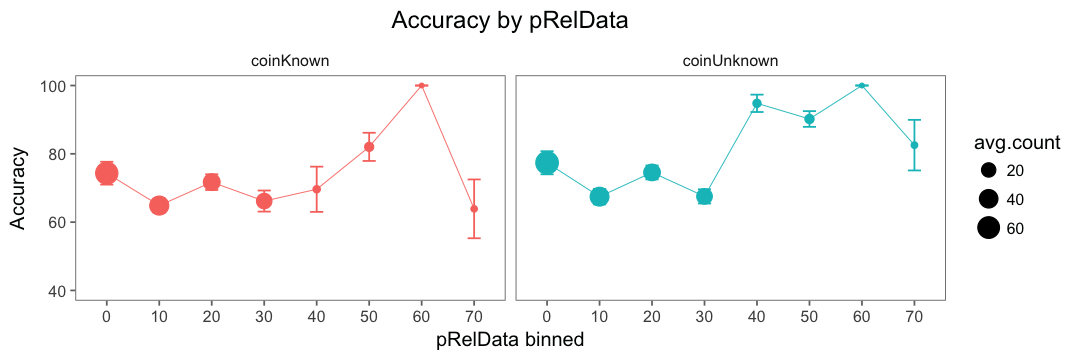

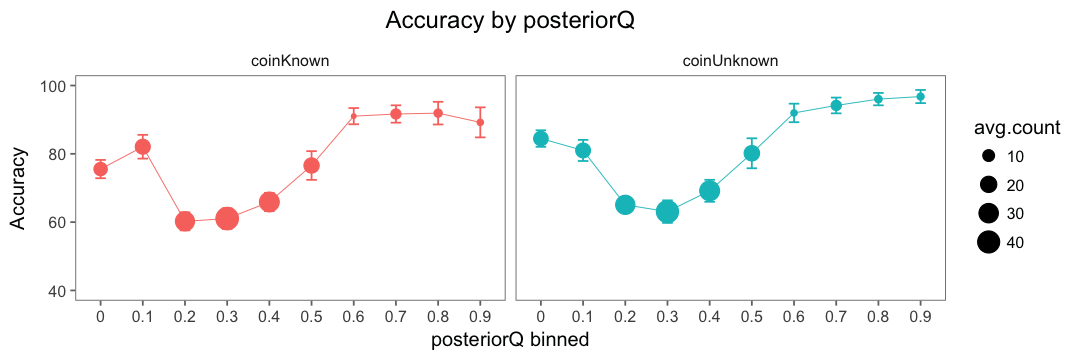

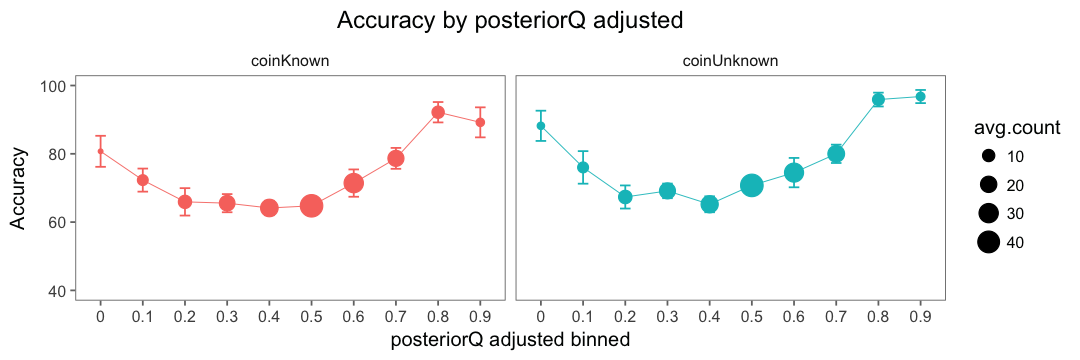

In [662]:
# Plot accuracies by pRelData and posteriorQ (including asjusted posteriorQ) for each condition

options(repr.plot.width = 9, repr.plot.height = 3)

# By pRelData

data %>% select(subjectID, condition, pRelData, matchPilot) %>%
         group_by(subjectID, condition, pRelData.bin = cut_interval(pRelData, 8)) %>%                                 
         summarise(accuracy = sum(matchPilot) / n() * 100, count = n()) %>%
         ungroup() %>%
         group_by(condition, pRelData.bin) %>%
         summarise(mean.accuracy.bypRelData = mean(accuracy), se.accuracy.bypRelData = sd(accuracy) / sqrt(n()), avg.count = mean(count)) %>%
         ggplot(aes(x = pRelData.bin, y = mean.accuracy.bypRelData, color = condition, size = avg.count)) +
         geom_point() +
         geom_errorbar(aes(x = pRelData.bin, ymin = mean.accuracy.bypRelData - se.accuracy.bypRelData, ymax = mean.accuracy.bypRelData + se.accuracy.bypRelData, color = condition), width = 0.25, lwd = 0.5, na.rm = TRUE) +
         geom_line(aes(color = condition, group = 1), lwd = 0.25) +
         facet_grid(. ~ condition) +
         scale_x_discrete(labels = seq(0, 80, 10)) +
         scale_y_continuous(limits = c(40, 100)) +
         labs(title = "Accuracy by pRelData", y = "Accuracy", x = "pRelData binned") +
         ggthemes::theme_few() +
         theme(plot.title = element_text(hjust = 0.5)) + guides(color = FALSE)

# By posteriorQ

data %>% select(subjectID, condition, posteriorQ, matchPilot) %>%
         group_by(subjectID, condition, posteriorQ.bin = cut_interval(posteriorQ, 10)) %>%                                 
         summarise(accuracy = sum(matchPilot) / n() * 100, count = n()) %>%
         ungroup() %>%
         group_by(condition, posteriorQ.bin) %>%
         summarise(mean.accuracy.byposteriorQ = mean(accuracy), se.accuracy.byposteriorQ = sd(accuracy) / sqrt(n()), avg.count = mean(count)) %>%
         ggplot(aes(x = posteriorQ.bin, y = mean.accuracy.byposteriorQ, color = condition, size = avg.count)) +
         geom_point() +
         geom_errorbar(aes(x = posteriorQ.bin, ymin = mean.accuracy.byposteriorQ - se.accuracy.byposteriorQ, ymax = mean.accuracy.byposteriorQ + se.accuracy.byposteriorQ, color = condition), width = 0.25, lwd = 0.5, na.rm = TRUE) +
         geom_line(aes(color = condition, group = 1), lwd = 0.25) +
         facet_grid(. ~ condition) +
         scale_x_discrete(labels = round(seq(0, 1, 1/10), 2)) +
         scale_y_continuous(limits = c(40, 100)) +
         labs(title = "Accuracy by posteriorQ", y = "Accuracy", x = "posteriorQ binned") +
         ggthemes::theme_few() +
         theme(plot.title = element_text(hjust = 0.5)) + guides(color = FALSE)

# By posteriorQ adjusted

data %>% select(subjectID, condition, posteriorQ.adjusted, matchPilot) %>%
         group_by(subjectID, condition, posteriorQ.adjusted.bin = cut_interval(posteriorQ.adjusted, 10)) %>%                                 
         summarise(accuracy = sum(matchPilot) / n() * 100, count = n()) %>%
         ungroup() %>%
         group_by(condition, posteriorQ.adjusted.bin) %>%
         summarise(mean.accuracy.byposteriorQ.adjusted = mean(accuracy), se.accuracy.byposteriorQ.adjusted = sd(accuracy) / sqrt(n()), avg.count = mean(count)) %>%
         ggplot(aes(x = posteriorQ.adjusted.bin, y = mean.accuracy.byposteriorQ.adjusted, color = condition, size = avg.count)) +
         geom_point() +
         geom_errorbar(aes(x = posteriorQ.adjusted.bin, ymin = mean.accuracy.byposteriorQ.adjusted - se.accuracy.byposteriorQ.adjusted, ymax = mean.accuracy.byposteriorQ.adjusted + se.accuracy.byposteriorQ.adjusted, color = condition), width = 0.25, lwd = 0.5, na.rm = TRUE) +
         geom_line(aes(color = condition, group = 1), lwd = 0.25) +
         facet_grid(. ~ condition) +
         scale_x_discrete(labels = round(seq(0, 1, 1/10), 2)) +
         scale_y_continuous(limits = c(40, 100)) +
         labs(title = "Accuracy by posteriorQ adjusted", y = "Accuracy", x = "posteriorQ adjusted binned") +
         ggthemes::theme_few() +
         theme(plot.title = element_text(hjust = 0.5)) + guides(color = FALSE)

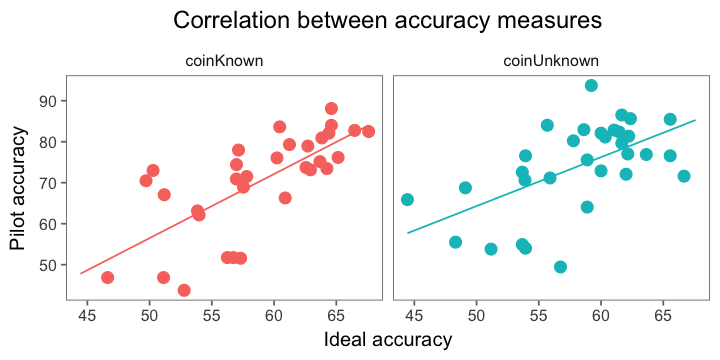

In [649]:
# Visualize correlation between "ideal" accuracy and accuracy with respect to pilot data for each condition

options(repr.plot.width = 6, repr.plot.height = 3)

accuracy.by.condition.ideal <- accuracy.by.condition %>% rename(accuracy.ideal = accuracy)

accuracy.all <- merge(accuracy.by.condition.ideal, accuracy.by.condition.wrt.pilot, sort = FALSE)

corr.accuracy <- accuracy.all %>% group_by(condition) %>%
                                  summarise(r = as.numeric(cor.test(accuracy, accuracy.ideal)$estimate),
                                            p = as.numeric(cor.test(accuracy, accuracy.ideal)$p.value))

accuracy.all %>% ggplot(aes(x = accuracy.ideal, y = accuracy, color = condition)) +
                 geom_point(size = 3) +
                 geom_smooth(method = "lm", se = FALSE, lwd = 0.5, fullrange = TRUE) +
                 facet_grid(. ~ condition) +
                 scale_x_continuous(breaks = seq(40, 80, 5)) +
                 scale_y_continuous(breaks = seq(40, 100, 10)) +
                 labs(title = "Correlation between accuracy measures", y = "Pilot accuracy", x = "Ideal accuracy") +
                 ggthemes::theme_few() +
                 theme(plot.title = element_text(hjust = 0.5)) + guides(color = FALSE)


## 8. Modeling choice data: Predictive models

In [792]:
glmer.control <- glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 200000))

model <- glmer(choice ~ 1 + scale(posteriorQ)*condition + cong*condition + (1 + scale(posteriorQ)*condition + cong*condition | subjectID),
               family = binomial(logit),
               data = data,
               control = glmer.control)

summary(model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ 1 + scale(posteriorQ) * condition + cong * condition +  
    (1 + scale(posteriorQ) * condition + cong * condition | subjectID)
   Data: data
Control: glmer.control

     AIC      BIC   logLik deviance df.resid 
 10492.2  10689.5  -5219.1  10438.2    10984 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-78.455  -0.595   0.070   0.610  10.224 

Random effects:
 Groups    Name                                   Variance Std.Dev. Corr       
 subjectID (Intercept)                            0.5505   0.7420              
           scale(posteriorQ)                      1.2528   1.1193    0.53      
           conditioncoinUnknown                   0.1541   0.3925    0.63  0.41
           congcongruent                          0.1110   0.3331    0.03  0.57
           scale(posteriorQ):conditioncoinUnknown 0.1929   0.4392    0.43  0.57
  

In [845]:
#m1 <- glm(choice ~ 1 + posteriorQ, family = binomial(logit), data = data)
#m2 <- glm(choice ~ 1 + posteriorQ*condition, family = binomial(logit), data = data)
#m3 <- glm(choice ~ 1 + posteriorQ*condition + cong*condition, family = binomial(logit), data = data)
#m4 <- glm(choice ~ 1 + posteriorQ*condition + cong*condition + posteriorQ*cong, family = binomial(logit), data = data)

#anova(m1, m2, m3, m4, test = 'Chisq')

new_pred <- abs(2*data$posteriorQ - 1)

summary(glm(choice ~ 1 + posteriorQ + new_pred, family = binomial(logit), data = data))

summary(glm(RT ~ 1 + posteriorQ + new_pred + condition + nHeads + seqLength + cong + pData, family = gaussian, data = data))


Call:
glm(formula = choice ~ 1 + posteriorQ + new_pred, family = binomial(logit), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5349  -0.8613   0.3871   0.9205   2.2516  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.3571     0.1146 -11.843  < 2e-16 ***
posteriorQ    5.8337     0.2047  28.497  < 2e-16 ***
new_pred     -1.1090     0.1381  -8.029 9.82e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 15151  on 11010  degrees of freedom
Residual deviance: 11873  on 11008  degrees of freedom
AIC: 11879

Number of Fisher Scoring iterations: 5



Call:
glm(formula = RT ~ 1 + posteriorQ + new_pred + condition + nHeads + 
    seqLength + cong + pData, family = gaussian, data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.21216  -0.43614  -0.07629   0.37398   2.43883  

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.9786709  0.0299984  65.959  < 2e-16 ***
posteriorQ           -0.6873166  0.0354027 -19.414  < 2e-16 ***
new_pred             -0.4861446  0.0258812 -18.784  < 2e-16 ***
conditioncoinUnknown -0.0765478  0.0115869  -6.606 4.12e-11 ***
nHeads               -0.0034610  0.0065459  -0.529   0.5970    
seqLength             0.1038295  0.0038807  26.755  < 2e-16 ***
congcongruent         0.0258517  0.0126658   2.041   0.0413 *  
pData                -0.0009696  0.0003879  -2.500   0.0124 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.3694913)

    Null devi

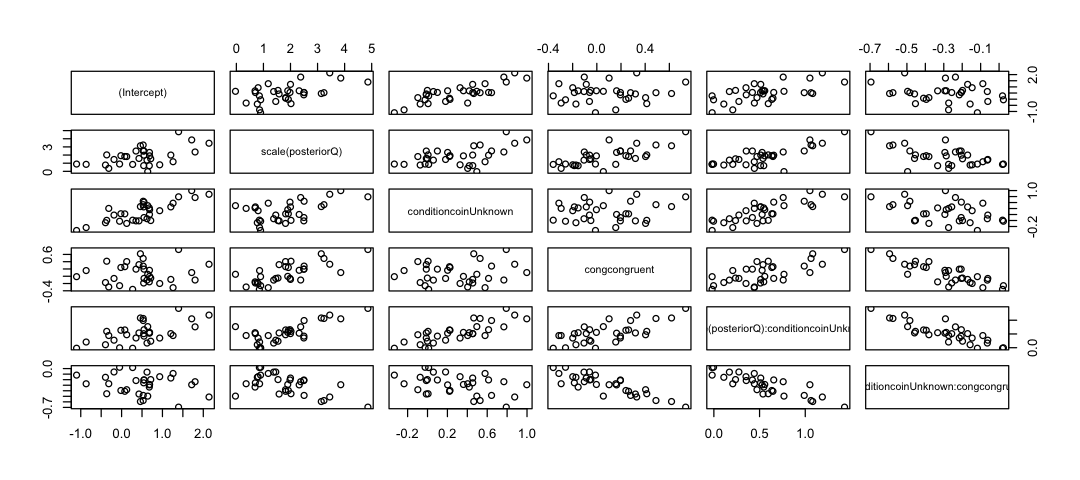

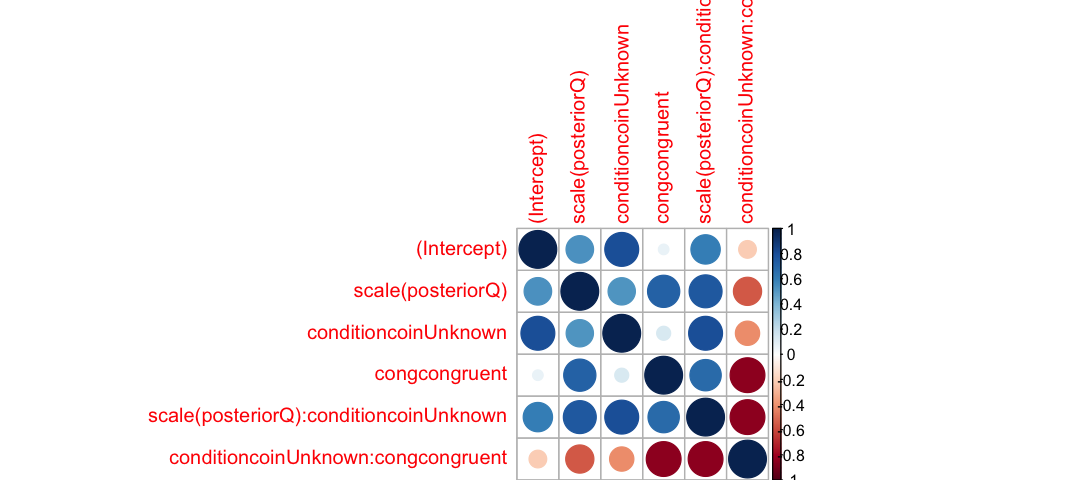

In [790]:
pairs(as.matrix(coef(model)$subjectID))
corrplot(as.matrix(cor(coef(model)$subjectID)))

In [807]:
require(caret)

set.seed(123)

train.indices <- vector(mode = "list", length = length(unique(data$subjectID)))
for(i in seq_along(unique(data$subjectID))) {
   train.indices[[i]] <- which(data$subjectID != unique(data$subjectID)[i]) }

names(train.indices) <- paste0("Subject", unique(data$subjectID))

train.control = trainControl(method = "cv", 
                             number = length(unique(data$subjectID)),
                             index = train.indices, 
                             classProbs =  TRUE)

logistic.Fit <- train(choice ~ 1 + posteriorQ*condition + cong*condition,
                      data = data,
                      family = "binomial", 
                      method = "glm",
                      trControl = train.control)


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient 

In [808]:
logistic.Fit

Generalized Linear Model 

11011 samples
    4 predictor
    2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (32 fold) 
Summary of sample sizes: 10668, 10660, 10655, 10660, 10655, 10659, ... 
Resampling results:

  Accuracy  Kappa    
  0.735747  0.4615439

 